## Multi-Hazard Exposure and Urbanization

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# lau_2023 = gpd.read_file('../../data/LAU_2023_EU/LAU_RG_01M_2023_4326.shp')
# lau_2023 = lau_2023[lau_2023['CNTR_CODE'] == 'FR' ]

# df_nuts3_name = pd.read_excel('../../data/LAU_2023_EU/EU-27-LAU-2024-NUTS-2024.xlsx', sheet_name='FR')
# lau_2023 = lau_2023.merge(df_nuts3_name[['NUTS 3 CODE', 'EU LAU CODE']], left_on='GISCO_ID', right_on='EU LAU CODE')
# df_nuts3_typo = pd.read_excel('../../data/LAU_2023_EU/NUTS2021-NUTS2024.xlsx', sheet_name='NUTS-3 Typologies')
# lau_2023 = lau_2023.merge(df_nuts3_typo[['NUTS-3 Code', 'Urban-Rural typology', 'Coastal regions']], left_on='NUTS 3 CODE', right_on='NUTS-3 Code', how='left')
# lau_2023 = lau_2023.drop(columns=['EU LAU CODE', 'NUTS-3 Code'])
# lau_2023.columns = lau_2023.columns[:-3].to_list() + (['NUTS3_ID', 'UR TYPO', 'COASTAL'])
# lau_2023.to_file('../../data/LAU_2023_EU/lau_2023_final.shp')

In [3]:
lau_2023 = gpd.read_file('../../data/LAU_2023_EU/lau_2023_final.shp')

In [4]:
lau_2023[lau_2023.CNTR_CODE == 'FR']

,GISCO_ID,CNTR_CODE,LAU_ID,LAU_NAME,POP_2023,POP_DENS_2,AREA_KM2,YEAR,NUTS3_ID,UR TYPO,COASTAL,geometry
0,FR_17315,FR,17315,Saint-Christophe,1362.0,NaN,98.405778,2023,FRI32,predominantly rural,coastal,"POLYGON ((-1.00913 46.13583, -0.95712 46.14357..."
1,FR_17316,FR,17316,Saint-Ciers-Champagne,397.0,NaN,21.734226,2023,FRI32,predominantly rural,coastal,"POLYGON ((-0.31534 45.47257, -0.31115 45.46544..."
2,FR_17317,FR,17317,Saint-Ciers-du-Taillon,559.0,NaN,25.392222,2023,FRI32,predominantly rural,coastal,"POLYGON ((-0.65606 45.40712, -0.65276 45.40782..."
3,FR_17318,FR,17318,Saint-Clément-des-Baleines,682.0,NaN,95.759454,2023,FRI32,predominantly rural,coastal,"POLYGON ((-1.51515 46.23076, -1.53147 46.22957..."
4,FR_17319,FR,17319,Sainte-Colombe,107.0,NaN,24.239725,2023,FRI32,predominantly rural,coastal,"POLYGON ((-0.28619 45.27560, -0.28838 45.27879..."
...,...,...,...,...,...,...,...,...,...,...,...,...
34940,FR_77446,FR,77446,Savins,603.0,NaN,91.156683,2023,FR102,intermediate,non-coastal,"POLYGON ((3.21999 48.50304, 3.20769 48.49314, ..."
34941,FR_62056,FR,62056,Audresselles,634.0,NaN,108.557041,2023,FRE12,intermediate,coastal,"POLYGON ((1.59394 50.81768, 1.58872 50.83150, ..."
34942,FR_62088,FR,62088,Bayenghem-lès-Seninghem,328.0,NaN,102.074824,2023,FRE12,intermediate,coastal,"POLYGON ((2.06420 50.69497, 2.06529 50.70995, ..."
34943,FR_49018,FR,49018,Baugé-en-Anjou,11829.0,NaN,43.761359,2023,FRG02,intermediate,non-coastal,"POLYGON ((-0.19090 47.52783, -0.19049 47.53475..."


In [3]:
nuts3_agg = lau_2023[['NUTS3_ID', 'geometry']].dissolve(by='NUTS3_ID', aggfunc='sum')
nuts3_agg['UR TYPO'] = lau_2023.groupby('NUTS3_ID')['UR TYPO'].first()
nuts3_agg['COASTAL'] = lau_2023.groupby('NUTS3_ID')['COASTAL'].first()

### France Land-Use Change

In [1]:
lu_files = glob.glob("../../data/Copernicus land-use changes/U2006*.csv")
#load all files an dconcatenate them
df_2006 = pd.concat([pd.read_csv(f) for f in lu_files])

lu_files = glob.glob("../../data/Copernicus land-use changes/U2018*.csv")

df_2018 = pd.concat([pd.read_csv(f) for f in lu_files])

df_2006 = df_2006.sort_values('LAU_ID')
df_2018 = df_2018.sort_values('LAU_ID')

df_2018.loc[df_2018['LAU_ID'].str.startswith('66'), 'forest_area'] = df_2018.loc[df_2018['LAU_ID'].str.startswith('66'), 'forest_area']  + (df_2006.loc[df_2006['LAU_ID'].str.startswith('66'), 'area']-df_2018.loc[df_2018['LAU_ID'].str.startswith('66'), 'area'])

df_2006[['urban%', 'cropland%', 'forest%', 'wetland%']] = df_2006[['urban_area', 'cropland_area', 'forest_area', 'wetland_area']] / df_2006[['urban_area', 'cropland_area', 'forest_area', 'wetland_area']].sum(axis=1).values.reshape(-1,1) * 100
df_2018[['urban%', 'cropland%', 'forest%', 'wetland%']] = df_2018[['urban_area', 'cropland_area', 'forest_area', 'wetland_area']] / df_2018[['urban_area', 'cropland_area', 'forest_area', 'wetland_area']].sum(axis=1).values.reshape(-1,1) * 100



lu_changes = df_2018.copy()
lu_changes[['urban', 'cropland', 'forest', 'wetland']] = df_2018[['urban%', 'cropland%', 'forest%', 'wetland%']] - df_2006[['urban%', 'cropland%', 'forest%', 'wetland%']]
lu_changes = lu_changes[['LAU_ID', 'urban', 'cropland', 'forest', 'wetland', 'area', 'AREA_KM2', 'POP_2023', 'LAU_NAME']]
lu_changes = lu_changes.merge(lau_2023[['GISCO_ID', 'NUTS3_ID', 'UR TYPO', 'COASTAL', 'LAU_ID']], left_on='LAU_ID', right_on='LAU_ID', how='left')[['LAU_ID', 'GISCO_ID','urban', 'cropland', 'forest', 'wetland', 'AREA_KM2', 'POP_2023', 'LAU_NAME', 'NUTS3_ID', 'UR TYPO', 'COASTAL']]


NameError: name 'glob' is not defined

In [5]:
df_2006 = df_2006.merge(lau_2023[['LAU_ID', 'NUTS3_ID']], left_on='LAU_ID', right_on='LAU_ID', how='left')
df_2018 = df_2018.merge(lau_2023[['LAU_ID', 'NUTS3_ID']], left_on='LAU_ID', right_on='LAU_ID', how='left')

Descriptive statistics on land-use changes in France in 2018 the mean county has a land use :

In [6]:
print(df_2018[['urban%', 'cropland%', 'forest%', 'wetland%']].describe())

             urban%     cropland%       forest%      wetland%
count  34825.000000  34825.000000  3.482500e+04  34825.000000
mean       7.726890     64.369758  2.769248e+01      0.210869
std       14.211227     27.424650  2.649060e+01      1.878477
min        0.000000      0.000000 -8.951259e-12      0.000000
25%        0.000000     45.872559  5.458306e+00      0.000000
50%        3.173632     70.978023  1.965044e+01      0.000000
75%        8.100360     87.416776  4.374550e+01      0.000000
max      100.000000    100.000000  1.000000e+02     90.116874


In [7]:
print(df_2006[['urban%', 'cropland%', 'forest%', 'wetland%']].describe())

             urban%     cropland%       forest%      wetland%
count  34825.000000  34825.000000  34825.000000  34825.000000
mean       6.503650     65.480431     27.810064      0.205855
std       13.262321     27.413591     26.573568      1.864008
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000     47.164715      5.485891      0.000000
50%        2.317832     72.356014     19.773065      0.000000
75%        6.463280     88.584788     43.890863      0.000000
max      100.000000    100.000000    100.000000     91.200748


The descriptive statistics of the land-use changes between 2006 and 2018 in France are as follows:

In [8]:
print(lu_changes[['urban', 'cropland', 'forest', 'wetland']].describe())

              urban      cropland        forest       wetland
count  34825.000000  34825.000000  34825.000000  34825.000000
mean       1.223240     -1.110673     -0.117580      0.005013
std        2.712596      2.996161      1.665798      0.369690
min      -25.815466    -42.181950    -64.423655    -33.822658
25%        0.000000     -1.489214     -0.048465      0.000000
50%        0.042146     -0.110720      0.000000      0.000000
75%        1.449793      0.003230      0.013663      0.000000
max       42.751595     63.669610     35.578961     23.005923


C:\Users\colin\AppData\Local\Temp\ipykernel_23568\1146461688.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nuts3_temp = nuts3_agg.merge(lu_changes[['NUTS3_ID', 'urban', 'cropland', 'forest', 'wetland', 'AREA_KM2']].groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['urban', 'cropland', 'forest', 'wetland']], weights=x['AREA_KM2'], axis=0), index=['urban', 'cropland', 'forest', 'wetland'])).reset_index(), left_on='NUTS3_ID', right_on='NUTS3_ID', how='left')


Text(0.5, 1.0, 'Wetland change (%) by NUTS3 region')

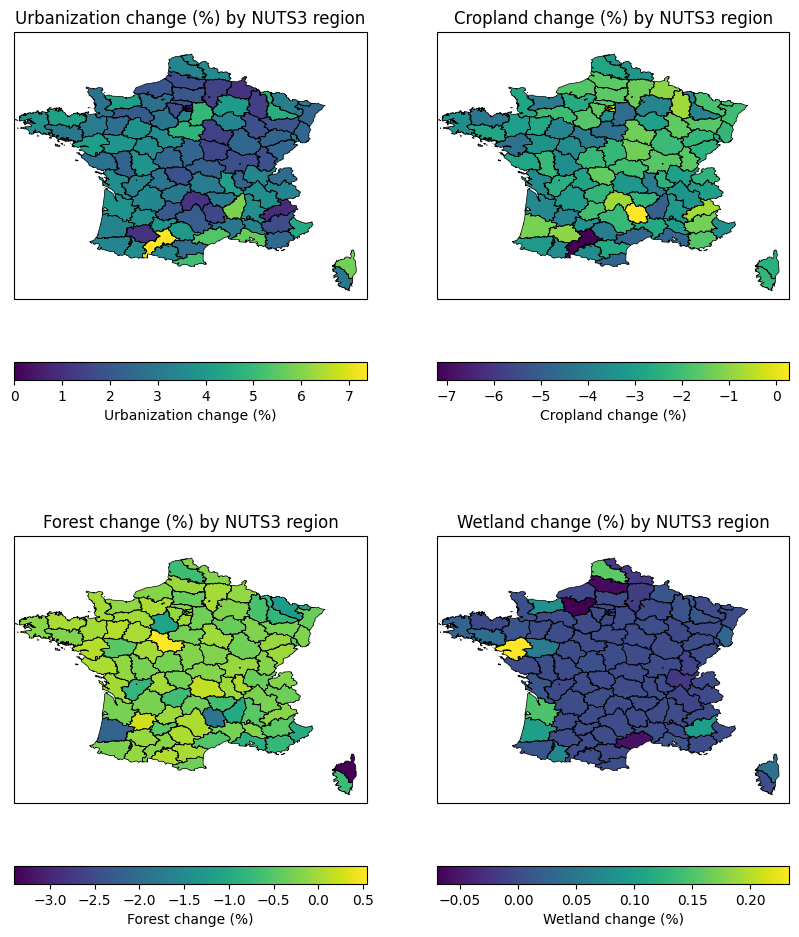

In [9]:
#aggregate at the NUTS3 level
nuts3_temp = nuts3_agg.merge(lu_changes[['NUTS3_ID', 'urban', 'cropland', 'forest', 'wetland', 'AREA_KM2']].groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['urban', 'cropland', 'forest', 'wetland']], weights=x['AREA_KM2'], axis=0), index=['urban', 'cropland', 'forest', 'wetland'])).reset_index(), left_on='NUTS3_ID', right_on='NUTS3_ID', how='left')
nuts3_temp[['urban', 'cropland', 'forest', 'wetland']] = nuts3_temp[['urban', 'cropland', 'forest', 'wetland']].fillna(0)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

nuts3_temp = nuts3_temp.to_crs(epsg=4326)

fig, axs = plt.subplots(2,2,figsize=(10, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax = axs[0,0]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts3_temp.plot(ax=ax, column='urban', legend=True, legend_kwds={'label': "Urbanization change (%)", 'orientation': "horizontal"})

ax.set_extent([-5, 10, 41, 52])
ax.set_title('Urbanization change (%) by NUTS3 region')

ax = axs[0,1]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts3_temp.plot(ax=ax, column='cropland', legend=True, legend_kwds={'label': "Cropland change (%)", 'orientation': "horizontal"})
ax.set_extent([-5, 10, 41, 52])

ax.set_title('Cropland change (%) by NUTS3 region')

ax = axs[1,0]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts3_temp.plot(ax=ax, column='forest', legend=True, legend_kwds={'label': "Forest change (%)", 'orientation': "horizontal"})
ax.set_extent([-5, 10, 41, 52])
ax.set_title('Forest change (%) by NUTS3 region')

ax = axs[1,1]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts3_temp.plot(ax=ax, column='wetland', legend=True, legend_kwds={'label': "Wetland change (%)", 'orientation': "horizontal"})
ax.set_extent([-5, 10, 41, 52])
ax.set_title('Wetland change (%) by NUTS3 region')

Text(0.5, 1.0, 'Urban Changes')

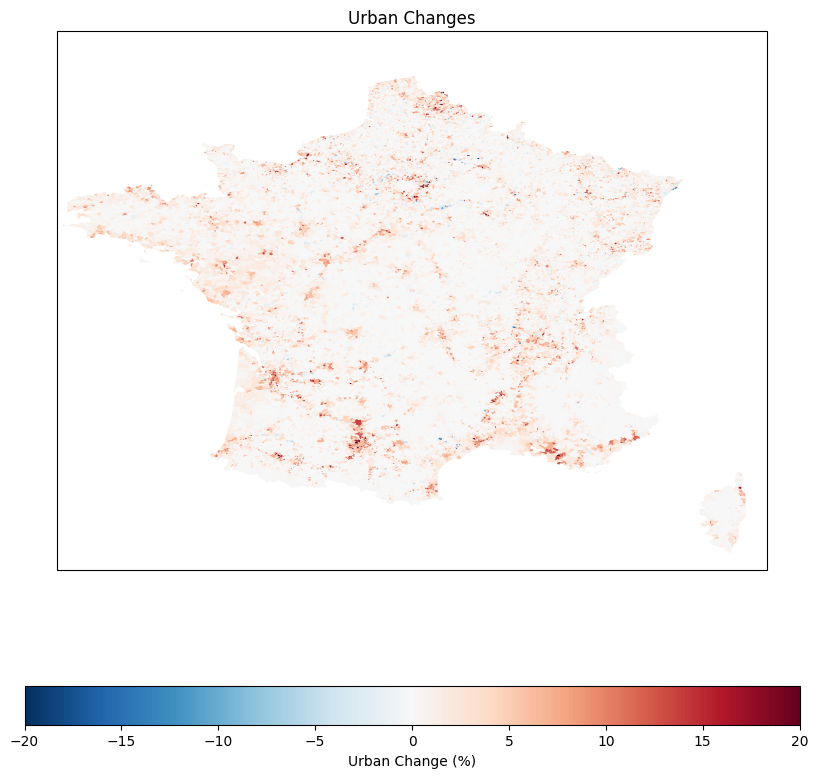

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

nuts3_temp = lau_2023.merge(lu_changes, left_on='LAU_ID', right_on='LAU_ID', how='left')

fig,ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
nuts3_temp.plot(column='urban', legend=True, cmap='RdBu_r', ax=ax, linewidth=1.2, transform=ccrs.PlateCarree(), legend_kwds={'orientation': 'horizontal', 'label': 'Urban Change (%)'}, vmax=20, vmin=-20)
ax.set_extent([-5, 10, 41, 52], crs=ccrs.PlateCarree())
ax.set_title('Urban Changes')

Text(0.5, 1.0, 'Urban-Rural Typology')

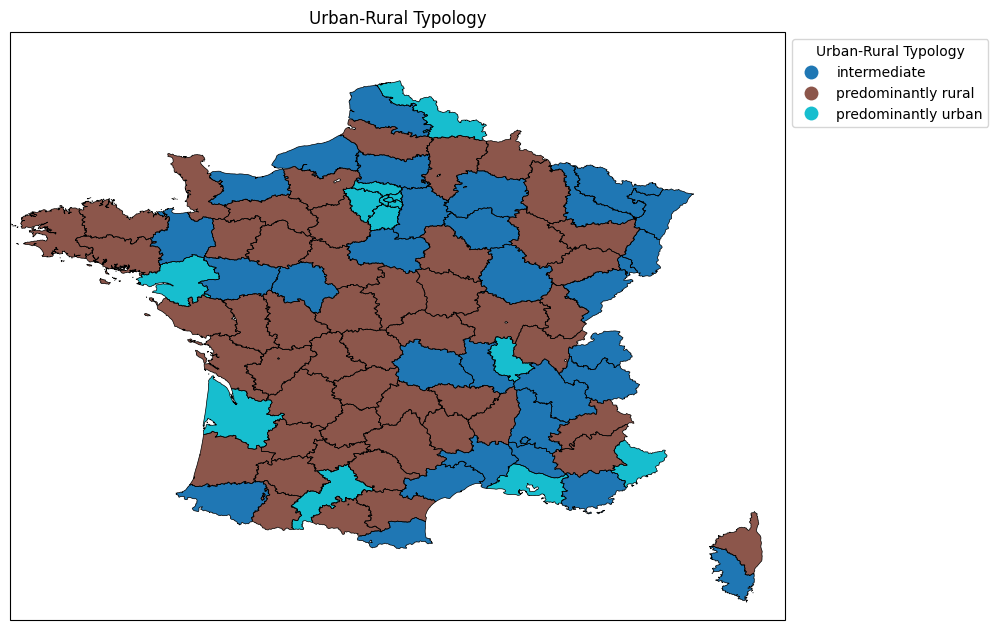

In [328]:
fig,ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

nuts3_agg.boundary.plot(ax =ax ,color='black', linewidth=0.5)
nuts3_agg.plot(ax=ax, column='UR TYPO', legend=True, legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left', 'title': 'Urban-Rural Typology'})
ax.set_extent([-5, 10, 41, 52])
ax.set_title('Urban-Rural Typology')

### Socio-economic data

In [10]:
disp_inc_2015 = gpd.read_file('../../data/disp_inc_2015.gpkg')
disp_inc_2015 = disp_inc_2015[disp_inc_2015.ISO=='FRA']
disp_inc_2015['Population'] = disp_inc_2015['Population'].astype(float)


In [11]:
df_urban = lu_changes.merge(disp_inc_2015[['AU_code', 'Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP', 'Population']], left_on='LAU_ID', right_on='AU_code', how='left')
df_urban[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP', 'Population']] = df_urban[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP', 'Population']].astype(float)
df_urban[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP', 'Population']].describe()

,Gini,Disp_Inc_PPP_2015,Disp_Inc_PPP,Population
count,30435.000000,30441.000000,30441.000000,3.044100e+04
mean,0.255010,16293.486084,16293.486084,1.176853e+03
std,0.022331,1719.817554,1719.817554,1.323034e+04
min,0.170441,10441.593603,10441.593603,7.500000e+01
25%,0.242237,15221.391686,15221.391686,2.450000e+02
50%,0.254317,16032.623720,16032.623720,5.020000e+02
75%,0.265959,17018.130606,17018.130606,1.146500e+03
max,0.440434,30209.992412,30209.992412,2.096399e+06


In [12]:
df_urban_missing = df_urban[df_urban['Disp_Inc_PPP_2015'].isna()]
df_urban_missing = df_urban_missing.merge(lau_2023[['LAU_ID', 'geometry']], left_on='LAU_ID', right_on='LAU_ID', how='left')
df_urban_missing = gpd.GeoDataFrame(df_urban_missing, geometry='geometry')
disp_missing = disp_inc_2015[~disp_inc_2015['AU_code'].isin(df_urban['LAU_ID'].to_list())]

In [13]:
df = gpd.sjoin(df_urban_missing[['GISCO_ID','LAU_ID', 'urban', 'cropland', 'forest', 'wetland', 'AREA_KM2', 'POP_2023', 'LAU_NAME', 'NUTS3_ID', 'UR TYPO', 'COASTAL', 'geometry']], disp_missing, op='intersects', how='left')
df = df.dropna(subset=['Gini'])
df = df[['LAU_ID', 'Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP']]
df[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP']] = df[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP']].astype(float)
df = df.groupby('LAU_ID').mean().reset_index()

c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [14]:
df_urban.loc[df_urban['LAU_ID'].isin(df['LAU_ID'].to_list()), ['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP']] = df[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP']].values

In [15]:
df_urban = df_urban.dropna(subset=['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP'])

C:\Users\colin\AppData\Local\Temp\ipykernel_13920\1610257045.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nuts3_temp = nuts3_agg.merge(df_urban[['NUTS3_ID', 'Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP', 'POP_2023']].groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP']], weights=x['POP_2023'], axis=0), index=['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP'])).reset_index(), left_on='NUTS3_ID', right_on='NUTS3_ID', how='left')


Text(0.5, 1.0, 'Disposible Income PPP 2015 by NUTS3 region')

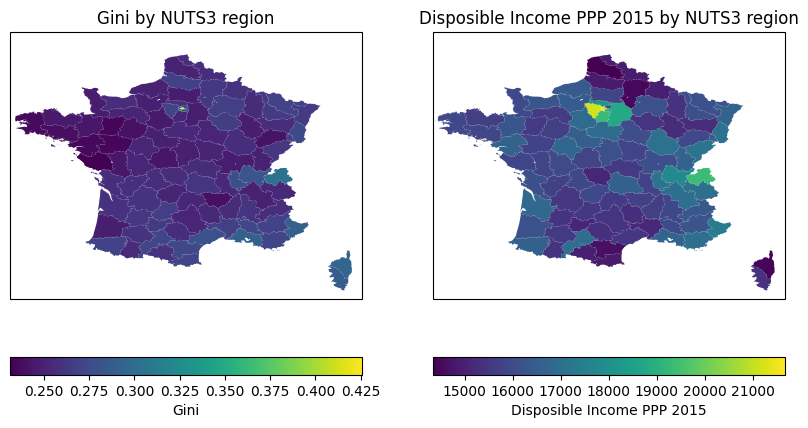

In [13]:
nuts3_temp = nuts3_agg.merge(df_urban[['NUTS3_ID', 'Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP', 'POP_2023']].groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP']], weights=x['POP_2023'], axis=0), index=['Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP'])).reset_index(), left_on='NUTS3_ID', right_on='NUTS3_ID', how='left')

# nuts3_temp = nuts3_agg.merge(df_urban[['UR TYPO', 'Gini', 'Disp_Inc_PPP_2015','Disp_Inc_PPP', 'POP_2023']].groupby('UR TYPO').mean().reset_index(), left_on='UR TYPO', right_on='UR TYPO', how='left')

fig, axs = plt.subplots(1,2,figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax = axs[0]
nuts3_temp = nuts3_temp.to_crs(epsg=4326)
nuts3_agg = nuts3_agg.to_crs(epsg=4326)
nuts3_temp.plot(ax=ax, column='Gini', legend=True, legend_kwds={'label': "Gini", 'orientation': "horizontal"})

ax.set_extent([-5, 10, 41, 52])
ax.set_title('Gini by NUTS3 region')

ax = axs[1]
nuts3_temp.plot(ax=ax, column='Disp_Inc_PPP_2015', legend=True, legend_kwds={'label': "Disposible Income PPP 2015", 'orientation': "horizontal"})

ax.set_extent([-5, 10, 41, 52])
ax.set_title('Disposible Income PPP 2015 by NUTS3 region')

We have the following correlations between the socio-economic data and the land-use changes in France between 2006 and 2018:

<Axes: >

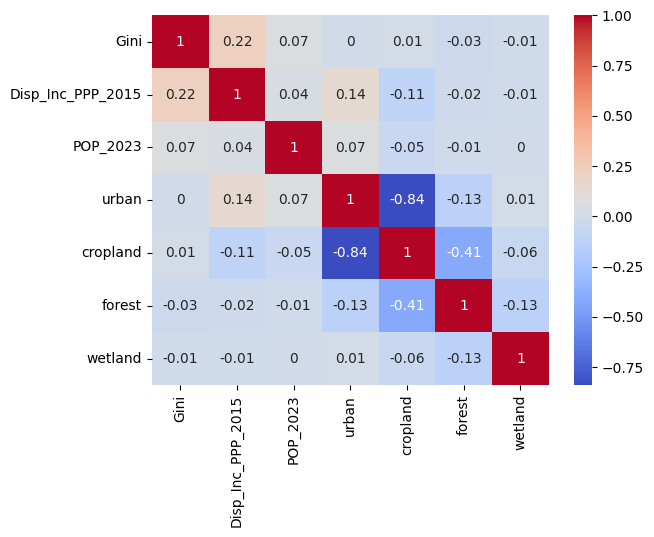

In [14]:
import seaborn as sns

sns.heatmap(round(df_urban[['Gini', 'Disp_Inc_PPP_2015', 'POP_2023', 'urban', 'cropland', 'forest', 'wetland']].corr(),2), annot=True, cmap='coolwarm')

Now we will do it and look at the correlation between Gini and urbanization and Disp_Inc_PPP_2015 and urbanization by NUTS3 region in France.

Text(0.5, 1.0, 'Disposible Income PPP 2015 correlation with Urban Change')

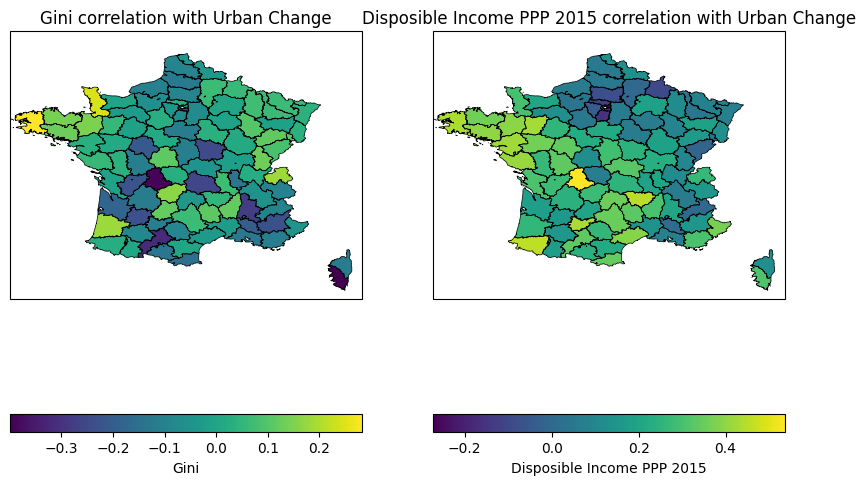

In [16]:
df_corr = df_urban.dropna(subset=['Gini', 'Disp_Inc_PPP_2015', 'urban', 'cropland', 'forest', 'wetland'])
df_corr = df_corr[['Gini', 'Disp_Inc_PPP_2015','urban', 'cropland', 'forest', 'wetland', 'NUTS3_ID']]
df_corr = df_corr.groupby('NUTS3_ID').corr().reset_index()


nuts_temp = nuts3_agg.merge(df_corr[df_corr['level_1']=='urban'][['NUTS3_ID', 'Gini', 'Disp_Inc_PPP_2015']], left_on='NUTS3_ID', right_on = 'NUTS3_ID', how='left')

fig,axs = plt.subplots(1,2, figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

nuts_temp = nuts_temp.to_crs(epsg=4326)
nuts3_agg = nuts3_agg.to_crs(epsg=4326)

ax = axs[0]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts_temp.plot(ax=ax, column='Gini', legend=True, legend_kwds={'label': "Gini", 'orientation': "horizontal"})
ax.set_extent([-5, 10, 41, 52])
ax.set_title('Gini correlation with Urban Change')

ax = axs[1]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts_temp.plot(ax=ax, column='Disp_Inc_PPP_2015', legend=True, legend_kwds={'label': "Disposible Income PPP 2015", 'orientation': "horizontal"})
ax.set_extent([-5, 10, 41, 52])
ax.set_title('Disposible Income PPP 2015 correlation with Urban Change')

In [17]:
df_corr = df_corr[df_corr['level_1']=='urban']
nuts3_agg.reset_index(inplace=True)
df_corr['UR TYPO'] = df_corr['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x]['UR TYPO'].values[0])

In [18]:
df_corr[['Gini', 'Disp_Inc_PPP_2015', 'UR TYPO']].groupby('UR TYPO').mean()

,Gini,Disp_Inc_PPP_2015
UR TYPO,,
intermediate,-0.046879,0.177500
predominantly rural,-0.001207,0.226125
predominantly urban,-0.093639,0.081062


0.14781461109790978


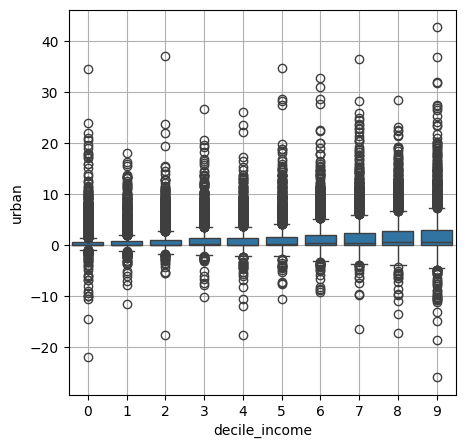

In [20]:
# Drop rows with missing values in the specified columns
df_corr = df_urban.dropna(subset=['Gini', 'Disp_Inc_PPP_2015', 'urban', 'cropland', 'forest', 'wetland'])

# Create a new column 'decile_income' by dividing 'Disp_Inc_PPP_2015' into 10 quantiles
df_corr['decile_income'] = pd.qcut(df_corr['Disp_Inc_PPP_2015'], 10, labels=False)

# Plot a boxplot of 'urban' changes against 'decile_income'
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(x='decile_income', y='urban', data=df_corr, ax=ax)
ax.grid()

# Print the slope of the regression line between 'decile_income' and 'urban'
from scipy.stats import linregress
print(linregress(df_corr['decile_income'], df_corr['urban']).slope)


C:\Users\colin\AppData\Local\Temp\ipykernel_50952\394452016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['decile_gini'] = pd.qcut(df_corr['Gini'], 10, labels=False)


<Axes: xlabel='decile_gini', ylabel='urban'>

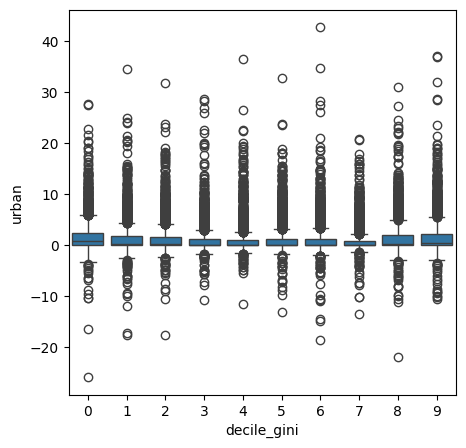

In [21]:
df_corr = df_urban.dropna(subset=['Gini', 'Disp_Inc_PPP_2015', 'Population', 'urban', 'cropland', 'forest', 'wetland'])
df_corr['decile_gini'] = pd.qcut(df_corr['Gini'], 10, labels=False)
# df_plot = df_corr[['Gini', 'Disp_Inc_PPP_2015', 'Population', 'urban', 'cropland', 'forest', 'wetland', 'decile_income']].groupby('decile_income').mean().reset_index()
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(x='decile_gini', y='urban', data=df_corr, ax=ax)
#print the slope of the regression line


Interesting to see that in the rural regions, the urbanization rate is positively correlated with the disposable income per capita, while in the urban regions, the urbanization rate is negatively correlated with the Gini index. The urbanization rate does not seem to be driven by the same factors in rural and urban regions. 

*Possible explanation:*
- In rural regions, attracting more people to the region might be a way to increase the disposable income per capita or the reverse might be true, that the increase in disposable income per capita is attracting more people to the region.
- In urban regions, much more areas are already urbanized. Urbanization happens in the places where the Gini index is lower, which might be a sign of gentrification.

### Exposition Data from *Spatial identification of regions exposed to multi-hazards at the pan-European level*

In [15]:
population_exposed = pd.read_excel('../../data/tiberiu/DATA_MH/Population%.xlsx')
population_exposed = population_exposed[population_exposed['CNTR_ID'].str.startswith('FR')]
# population_exposed = population_exposed.merge(nuts3[['LAU_ID', 'NUTS3_ID', 'AREAkm']], left_on='LAU_ID', right_on='LAU_ID', how='left')

In [16]:
nuts3_2013 = gpd.read_file('C:/Users/colin/Downloads/NUTS3_2013/LAU_2013.shp')
nuts3_2013 = nuts3_2013[nuts3_2013.CNTRY=='FR']

In [17]:
lau_temp = gpd.sjoin(lau_2023, nuts3_2013[['COMM_ID', 'geometry']])
lau_temp['intersection_area'] = lau_temp.apply(lambda row: row['geometry'].intersection(nuts3_2013.loc[row['index_right'], 'geometry']).area, axis=1)
lau_temp = lau_temp.sort_values('intersection_area', ascending=False)
lau_temp = lau_temp.groupby('GISCO_ID').first().reset_index()


C:\Users\colin\AppData\Local\Temp\ipykernel_13920\968362620.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4258

  lau_temp = gpd.sjoin(lau_2023, nuts3_2013[['COMM_ID', 'geometry']])


In [18]:
desc = population_exposed[['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI']].describe()
desc.iloc[0] = desc.iloc[0] * 100 / population_exposed.shape[0]
desc

,pop%_CFL,pop%_EQ,pop%_FL,pop%_LNDSL,pop%_SUBS,pop%_WUI
count,2.663167,13.936511,20.126870,39.080743,65.061658,3.822492
mean,18.996411,0.057112,11.538436,12.538501,21.010166,48.221470
std,29.529729,0.158942,18.310732,13.220413,37.675972,34.257396
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.565679,0.000000,0.436418,1.723645,0.000000,12.699130
50%,4.392032,0.000000,3.522251,8.861211,0.000000,50.006563
75%,22.026162,0.000000,14.337390,19.885606,18.408424,79.948898
max,100.000000,0.620000,100.000000,100.000000,100.000000,100.000000


In [19]:
pop_exp_df = population_exposed.merge(lau_temp[['GISCO_ID', 'NUTS3_ID', 'COMM_ID', 'AREA_KM2', 'UR TYPO']], left_on='LAU_ID', right_on='COMM_ID', how='left')
pop_exp_df = pop_exp_df.dropna(subset=['COMM_ID'])


C:\Users\colin\AppData\Local\Temp\ipykernel_13920\3566961529.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nuts3_temp = pop_exp_df[['NUTS3_ID', 'pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI', 'AREA_KM2']].fillna(0).groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI']], weights=x['AREA_KM2'], axis=0), index=['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI'])).reset_index()


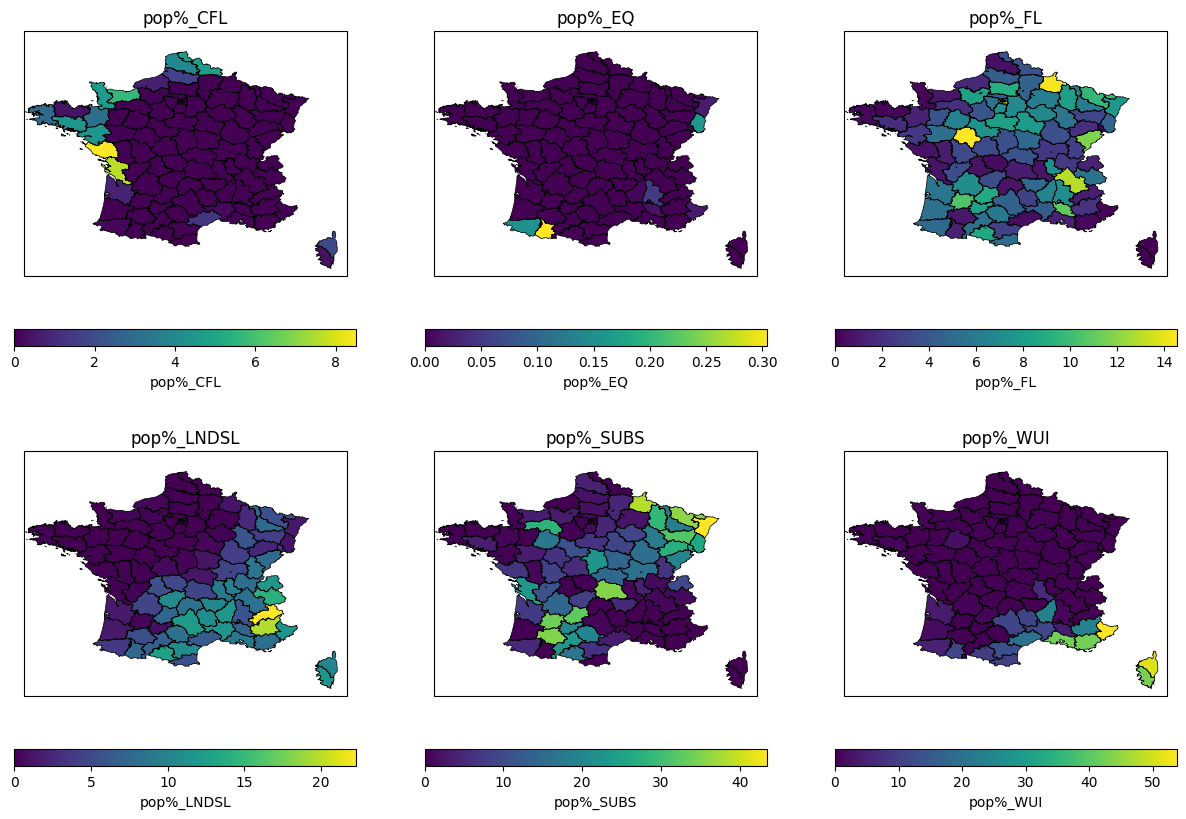

In [20]:
nuts3_temp = pop_exp_df[['NUTS3_ID', 'pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI', 'AREA_KM2']].fillna(0).groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI']], weights=x['AREA_KM2'], axis=0), index=['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI'])).reset_index()
nuts3_temp = nuts3_agg.merge(nuts3_temp, left_on='NUTS3_ID',
                            right_on='NUTS3_ID', how='left')
nuts3_temp = nuts3_temp.to_crs(epsg=4326)


fig, axs = plt.subplots(2,3,figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
var_list = ['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI']
for var in var_list:
    ax = axs[var_list.index(var) // 3, var_list.index(var) % 3]
    nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
    nuts3_temp.plot(ax=ax, column=var, legend=True, legend_kwds={'label': var, 'orientation': "horizontal"})
    ax.set_extent([-5, 10, 41, 52])
    ax.set_title(var)

In [21]:
pop_exp_df[['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI', 'UR TYPO']].groupby('UR TYPO').mean()

,pop%_CFL,pop%_EQ,pop%_FL,pop%_LNDSL,pop%_SUBS,pop%_WUI
UR TYPO,,,,,,
intermediate,21.440694,0.051676,12.467407,12.861875,21.973656,47.686328
predominantly rural,15.530191,0.085583,11.033634,11.964964,21.970833,46.072414
predominantly urban,26.607864,0.028024,11.420496,14.040274,14.733757,54.975022


In [22]:
# Bootstrap resampling function
def bootstrap_ci(data1, data2, n_bootstrap=1000, ci=95):
    boot_diffs = []
    n1, n2 = len(data1), len(data2)
    
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, n1, replace=True)
        sample2 = np.random.choice(data2, n2, replace=True)
        boot_diffs.append(sample1.mean() - sample2.mean())
        
    lower = np.percentile(boot_diffs, (100 - ci) / 2)
    upper = np.percentile(boot_diffs, 100 - (100 - ci) / 2)
    return lower, upper


In [23]:
#for CF check if the mean urban wetland change is higher for the counties exposed vs the ones not exposed

pop_exp_df = pop_exp_df.merge(lu_changes[['urban', 'wetland', 'forest', 'cropland', 'GISCO_ID']], left_on='GISCO_ID', right_on='GISCO_ID', how='left')	
pop_exp_df = pop_exp_df.dropna(subset=['urban'])

mean_diff = pop_exp_df.dropna(subset=['pop%_CFL'])['urban'].mean() - pop_exp_df['urban'].mean()
conf_interval = 1.96 * (pop_exp_df.dropna(subset=['pop%_CFL'])['urban'].std() / np.sqrt(len(pop_exp_df.dropna(subset=['pop%_CFL']))))
print(f"Mean difference for CFL: {mean_diff}, 95% CI: [{mean_diff - conf_interval}, {mean_diff + conf_interval}]")

mean_diff = pop_exp_df.dropna(subset=['pop%_FL'])['urban'].mean() - pop_exp_df['urban'].mean()
conf_interval = 1.96 * (pop_exp_df.dropna(subset=['pop%_FL'])['urban'].std() / np.sqrt(len(pop_exp_df.dropna(subset=['pop%_FL']))))
print(f"Mean difference for FL: {mean_diff}, 95% CI: [{mean_diff - conf_interval}, {mean_diff + conf_interval}]")

mean_diff = pop_exp_df.dropna(subset=['pop%_WUI'])['urban'].mean() - pop_exp_df['urban'].mean()
conf_interval = 1.96 * (pop_exp_df.dropna(subset=['pop%_WUI'])['urban'].std() / np.sqrt(len(pop_exp_df.dropna(subset=['pop%_WUI']))))
print(f"Mean difference for WUI: {mean_diff}, 95% CI: [{mean_diff - conf_interval}, {mean_diff + conf_interval}]")

mean_diff = pop_exp_df.dropna(subset=['pop%_LNDSL'])['urban'].mean() - pop_exp_df['urban'].mean()
conf_interval = 1.96 * (pop_exp_df.dropna(subset=['pop%_LNDSL'])['urban'].std() / np.sqrt(len(pop_exp_df.dropna(subset=['pop%_LNDSL']))))
print(f"Mean difference for LNDSL: {mean_diff}, 95% CI: [{mean_diff - conf_interval}, {mean_diff + conf_interval}]")

mean_diff = pop_exp_df.dropna(subset=['pop%_EQ'])['urban'].mean() - pop_exp_df['urban'].mean()
conf_interval = 1.96 * (pop_exp_df.dropna(subset=['pop%_EQ'])['urban'].std() / np.sqrt(len(pop_exp_df.dropna(subset=['pop%_EQ']))))
print(f"Mean difference for EQ: {mean_diff}, 95% CI: [{mean_diff - conf_interval}, {mean_diff + conf_interval}]")

mean_diff = pop_exp_df.dropna(subset=['pop%_SUBS'])['urban'].mean() - pop_exp_df['urban'].mean()
conf_interval = 1.96 * (pop_exp_df.dropna(subset=['pop%_SUBS'])['urban'].std() / np.sqrt(len(pop_exp_df.dropna(subset=['pop%_SUBS']))))
print(f"Mean difference for SUBS: {mean_diff}, 95% CI: [{mean_diff - conf_interval}, {mean_diff + conf_interval}]")


Mean difference for CFL: 1.0425935433519917, 95% CI: [0.856823995298856, 1.2283630914051276]
Mean difference for FL: 0.5877741681038131, 95% CI: [0.5089017023544699, 0.6666466338531564]
Mean difference for WUI: 1.184401954669456, 95% CI: [0.9934185021612909, 1.375385407177621]
Mean difference for LNDSL: 0.04356290777069982, 95% CI: [-0.0017385940378205345, 0.08886440957922018]
Mean difference for EQ: 0.0888345282048093, 95% CI: [0.011384390176269757, 0.16628466623334887]
Mean difference for SUBS: 0.24675241487968358, 95% CI: [0.21049845647089413, 0.283006373288473]


In [24]:
# Bootstrap resampling function
def bootstrap_ci(data1, data2, n_bootstrap=1000, ci=95):
    boot_diffs = []
    n1, n2 = len(data1), len(data2)
    
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, n1, replace=True)
        sample2 = np.random.choice(data2, n2, replace=True)
        boot_diffs.append(sample1.mean() - sample2.mean())
        
    lower = np.percentile(boot_diffs, (100 - ci) / 2)
    upper = np.percentile(boot_diffs, 100 - (100 - ci) / 2)
    return lower, upper



Here we tested the difference of urbanization rate between the exposed counties and the mean rate of urbanization. 

We did the same analysis but with the 10% most exposed counties instead of all the exposed counties.

C:\Users\colin\AppData\Local\Temp\ipykernel_50952\2823622725.py:9: RuntimeWarning: Mean of empty slice.
  boot_diffs.append(sample1.mean() - sample2.mean())
c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


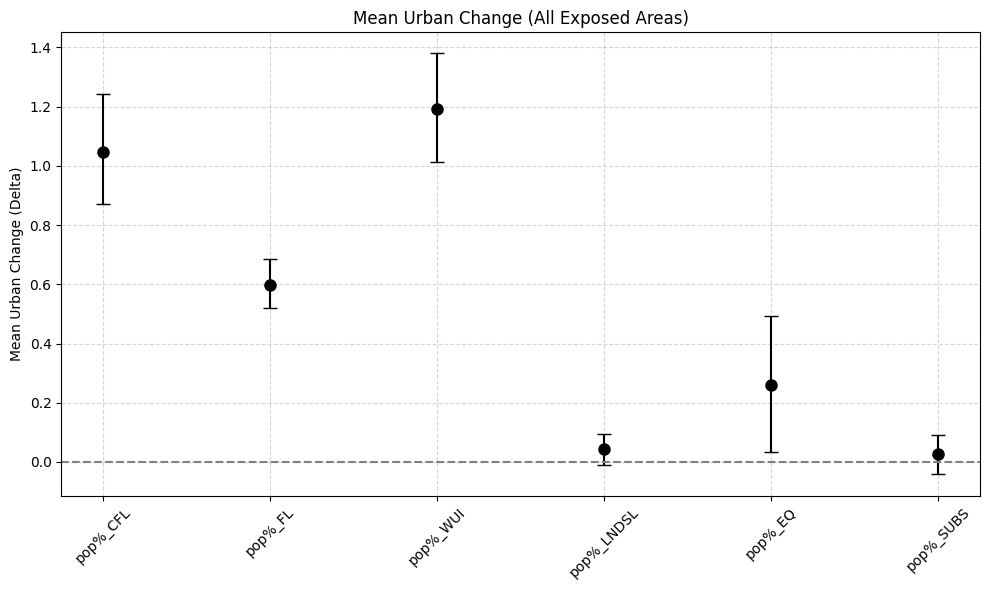

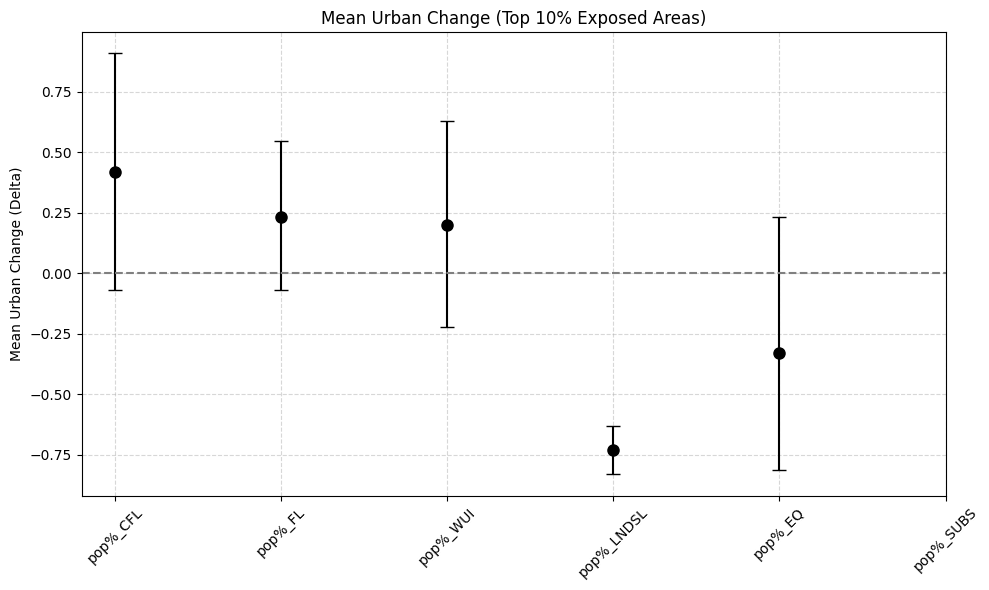

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Lists to store results
vars_labels = ['pop%_CFL', 'pop%_FL', 'pop%_WUI', 'pop%_LNDSL', 'pop%_EQ', 'pop%_SUBS']
deltas, ci_lowers, ci_uppers = [], [], []
deltas_bis, ci_lowers_bis, ci_uppers_bis = [], [], []

for var in vars_labels:
    mean_exposed = pop_exp_df.loc[pop_exp_df[var] > 0, 'urban'].mean()
    mean_all = pop_exp_df['urban'].mean()
    data_exposed = pop_exp_df.loc[pop_exp_df[var] > 0, 'urban']

    thr = pop_exp_df.loc[pop_exp_df[var] > 0, var].quantile(0.90)
    data_q90 = pop_exp_df.loc[pop_exp_df[var] > thr, 'urban']

    delta = mean_exposed - mean_all
    lower, upper = bootstrap_ci(data_exposed, pop_exp_df['urban'])

    deltas.append(delta)
    ci_lowers.append(lower)
    ci_uppers.append(upper)

    delta_bis = data_q90.mean() - mean_all
    lower_bis, upper_bis = bootstrap_ci(data_q90, pop_exp_df['urban'])

    deltas_bis.append(delta_bis)
    ci_lowers_bis.append(lower_bis)
    ci_uppers_bis.append(upper_bis)

def plot_deltas_with_ci(labels, deltas, lowers, uppers, title):
    x = np.arange(len(labels))
    ci_err = [np.array(deltas) - np.array(lowers), np.array(uppers) - np.array(deltas)]

    plt.figure(figsize=(10, 6))
    plt.errorbar(x, deltas, yerr=ci_err, fmt='o', color='black', capsize=5, markersize=8, label='Mean Δ Urban')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xticks(x, labels, rotation=45)
    plt.ylabel('Mean Urban Change (Delta)')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Plot for all exposed areas
plot_deltas_with_ci(vars_labels, deltas, ci_lowers, ci_uppers,
                    'Mean Urban Change (All Exposed Areas)')

# Plot for top 10% exposed areas
plot_deltas_with_ci(vars_labels, deltas_bis, ci_lowers_bis, ci_uppers_bis,
                    'Mean Urban Change (Top 10% Exposed Areas)')

The graphs show that the exposed counties have a higher rate of urbanization than the mean rate of urbanization in France. But if we look at the 10% most exposed counties, the rate of urbanization is not as significant as for all the exposed counties. It can signify that the most exposed counties are not the most urbanized counties, even if the overall trend is that the exposed counties are more urbanized than the mean rate of urbanization.

#### Now compare correlation also with income data

In [130]:
pop_exp_df = pop_exp_df.merge(df_urban[['Disp_Inc_PPP', 'Gini', 'GISCO_ID']], left_on='GISCO_ID', right_on='GISCO_ID', how='left')

# population_exposed_urban[['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI']] = population_exposed_urban[['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI']].fillna(0)



In [131]:
pop_exp_df

,FID,LAU_ID,CNTR_ID,CNTR_name,HRpcode,pop%_CFL,pop%_EQ,pop%_FL,pop%_LNDSL,pop%_SUBS,...,NUTS3_ID,COMM_ID,AREA_KM2,UR TYPO,urban,wetland,forest,cropland,Disp_Inc_PPP,Gini
0,39518,FR1175130116,FR,France,FR101,NaN,NaN,0.775540,NaN,NaN,...,FR101,FR1175130116,20563.647760,predominantly urban,0.000000,0.0,0.000000,0.000000,20984.416222,0.425874
1,39523,FR1177107013,FR,France,FR102,NaN,NaN,NaN,NaN,NaN,...,FR102,FR1177107013,25.131704,intermediate,-0.001287,0.0,-0.013529,0.014816,19868.828178,0.262944
2,39525,FR1177107042,FR,France,FR102,NaN,NaN,0.588599,NaN,0.0,...,FR102,FR1177107042,324.404738,intermediate,0.709766,0.0,0.005156,-0.714922,18986.781512,0.221542
3,39526,FR1177107063,FR,France,FR102,NaN,NaN,0.526714,NaN,0.0,...,FR102,FR1177107063,168.945137,intermediate,2.131051,0.0,-1.946654,-0.184397,19883.496657,0.262944
4,39527,FR1177107070,FR,France,FR102,NaN,NaN,1.447758,NaN,0.0,...,FR102,FR1177107070,82.229074,intermediate,0.072631,0.0,0.000909,-0.073540,18979.011342,0.262944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34809,76071,FR942B529188,FR,France,FR832,NaN,NaN,NaN,33.186181,0.0,...,FRM02,FR942B529188,30.591031,predominantly rural,-0.002874,0.0,-1.466193,1.469067,14616.310408,0.302373
34810,76072,FR942B529205,FR,France,FR832,NaN,NaN,NaN,19.433027,0.0,...,FRM02,FR942B529205,50.474540,predominantly rural,3.596362,0.0,-0.008174,-3.588188,14506.713495,0.302373
34811,76073,FR942B529239,FR,France,FR832,NaN,NaN,NaN,24.568335,0.0,...,FRM02,FR942B529239,13.310629,predominantly rural,0.000889,0.0,0.012408,-0.013297,16193.325254,0.302373
34812,76074,FR942B529298,FR,France,FR832,7.255743,NaN,NaN,NaN,0.0,...,FRM02,FR942B529298,92.266855,predominantly rural,0.438419,0.0,-0.202835,-0.235583,NaN,NaN


<Axes: >

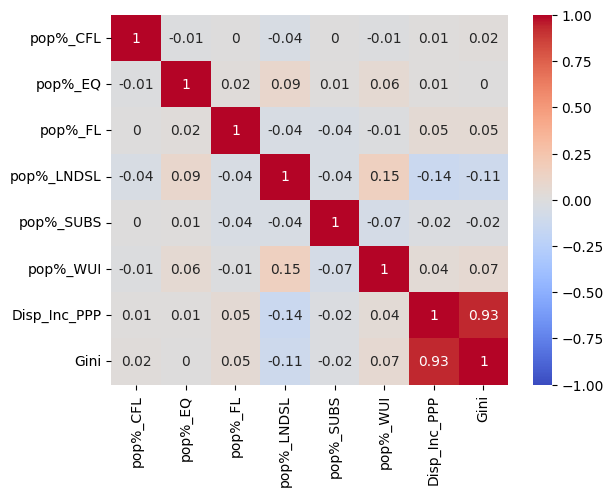

In [138]:
df_corr = pop_exp_df[['pop%_CFL', 'pop%_EQ', 'pop%_FL', 'pop%_LNDSL', 'pop%_SUBS', 'pop%_WUI', 'Disp_Inc_PPP', 'Gini']].fillna(0)
df_corr = df_corr.corr()
df_corr = round(df_corr, 2)

sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

### Now with climate data

In [16]:
clim_df = pd.read_csv('../../data/indicesQ50_25021114242922763.txt', sep=';', comment='#', header=None)
clim_df.columns = ['index', 'lat', 'lon', 'scenario', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'nan']
clim_df = clim_df.drop('nan', axis=1)


In [17]:

#map the data_new to each county in the shapefile based on the closest lat lon
from scipy.spatial import distance
def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

clim_shp = lau_2023.copy()
clim_shp = clim_shp.to_crs(epsg=4326)
clim_shp['lat'] = clim_shp.geometry.centroid.y
clim_shp['lon'] = clim_shp.geometry.centroid.x
clim_shp['index'] = clim_shp.apply(lambda x: closest_node([x['lat'], x['lon']], clim_df[['lat', 'lon']].values), axis=1)



C:\Users\colin\AppData\Local\Temp\ipykernel_23568\1818603049.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clim_shp['lat'] = clim_shp.geometry.centroid.y
C:\Users\colin\AppData\Local\Temp\ipykernel_23568\1818603049.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clim_shp['lon'] = clim_shp.geometry.centroid.x


In [18]:
clim_shp['pr_cum'] = clim_shp['index'].apply(lambda x: clim_df.loc[x, 'pr_cum'])
clim_shp['tasmax'] = clim_shp['index'].apply(lambda x: clim_df.loc[x, 'tasmax'])
clim_shp['wf_risk'] = clim_shp['index'].apply(lambda x: clim_df.loc[x, 'wf_risk'])
clim_shp['droughts_day'] = clim_shp['index'].apply(lambda x: clim_df.loc[x, 'droughts_day'])
clim_shp['day30'] = clim_shp['index'].apply(lambda x: clim_df.loc[x, 'day30'])

clim_shp['decile_pr_cum'] = pd.qcut(clim_shp['pr_cum'], 10, labels=False)
clim_shp['decile_tasmax'] = pd.qcut(clim_shp['tasmax'], 10, labels=False)
clim_shp['decile_wf_risk'] = pd.qcut(clim_shp['wf_risk'], 10, labels=False, duplicates='drop')
clim_shp['decile_droughts_day'] = pd.qcut(clim_shp['droughts_day'], 10, labels=False)
clim_shp['decile_day30'] = pd.qcut(clim_shp['day30'], 10, labels=False)

In [19]:
clim_shp[['tasmax', 'pr_cum', 'wf_risk', 'droughts_day', 'day30']].describe()

,tasmax,pr_cum,wf_risk,droughts_day,day30
count,34945.000000,34945.000000,34945.000000,34945.000000,34945.000000
mean,22.752481,41.881663,2.092030,87.834397,8.080535
std,2.048591,14.403089,4.838805,36.649517,6.401689
min,7.510000,26.640000,0.000000,0.000000,0.000000
25%,21.550000,33.110000,0.000000,62.000000,3.600000
50%,22.790000,36.950000,1.000000,91.000000,6.600000
75%,23.940000,44.580000,2.000000,114.000000,10.700000
max,29.490000,178.530000,58.000000,239.000000,49.600000


C:\Users\colin\AppData\Local\Temp\ipykernel_23568\2565192046.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clim_agg = clim_shp.groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']], weights=x['AREA_KM2'], axis=0), index=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day'])).reset_index()


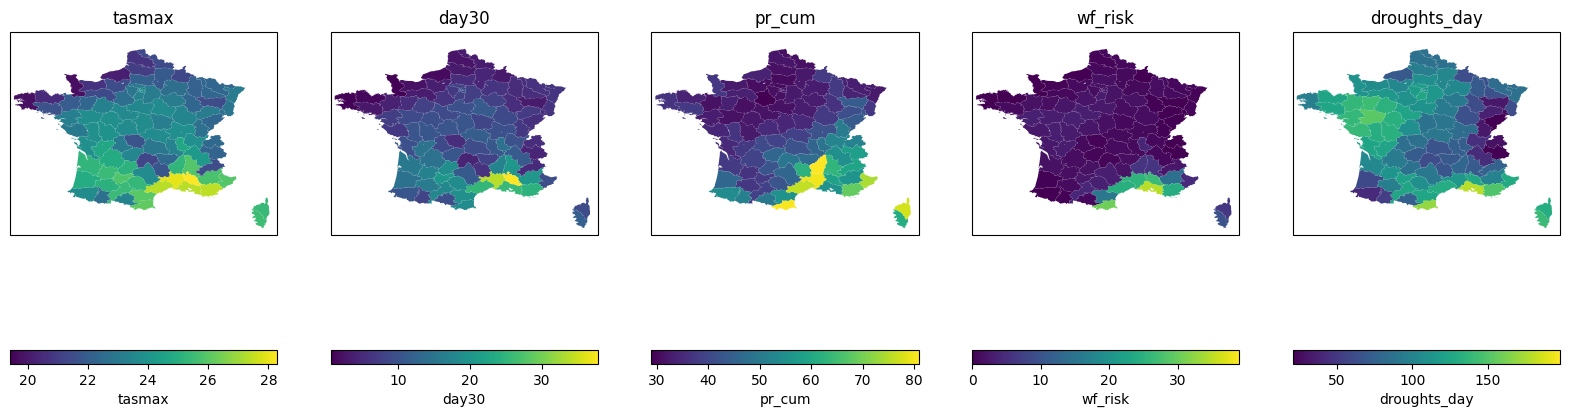

In [20]:
clim_agg = clim_shp.groupby('NUTS3_ID').apply(lambda x: pd.Series(np.average(x[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']], weights=x['AREA_KM2'], axis=0), index=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day'])).reset_index()
clim_agg = nuts3_agg.merge(clim_agg, left_on='NUTS3_ID', right_on='NUTS3_ID', how='left')
fig, axs = plt.subplots(1,5,figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

var_list = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']
for var in var_list:
    ax = axs[var_list.index(var)]
    clim_agg.plot(ax=ax, column=var, legend=True, legend_kwds={'label': var, 'orientation': "horizontal"})
    ax.set_extent([-5, 10, 41, 52])
    ax.set_title(var)

Text(0.5, 1.0, 'Correlation Matrix Between Climate and Land Use Changes Variables')

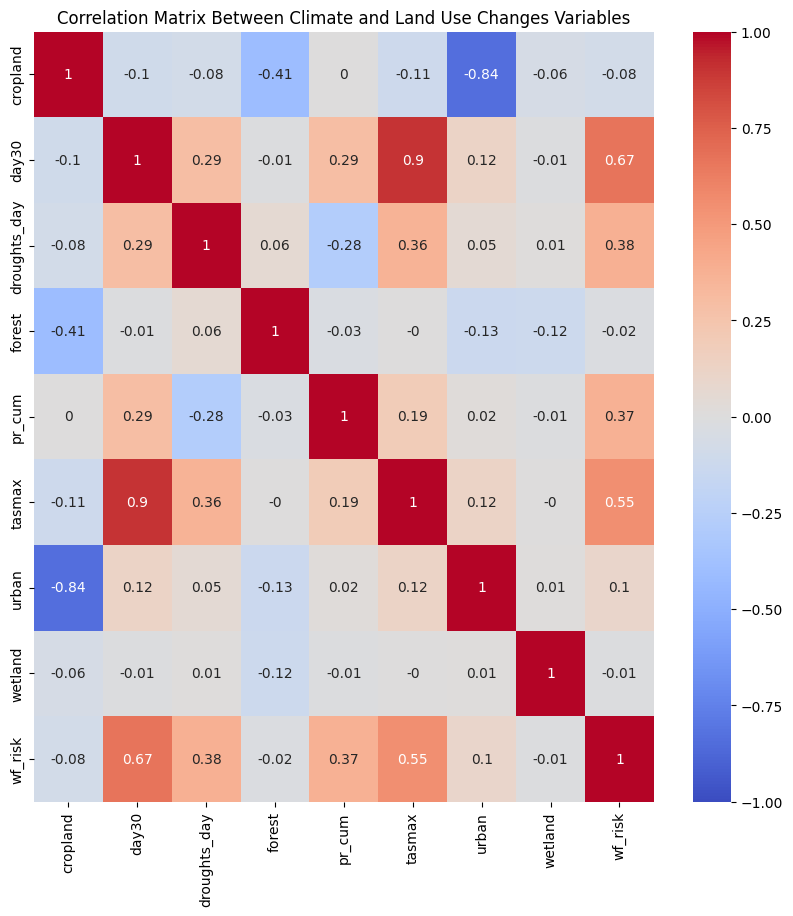

In [21]:
clim_df = clim_shp[['LAU_ID', 'AREA_KM2', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']]
clim_df = clim_df.merge(df_urban.drop(columns='AREA_KM2'), left_on='LAU_ID', right_on='LAU_ID', how='left')

clim_df_corr = clim_df[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'urban', 'cropland', 'forest', 'wetland']].corr()

# nan_corr = ['urban', 'cropland', 'forest', 'wetland']
# for var in nan_corr:
#     for var2 in nan_corr:
#         clim_df_corr.loc[var, var2] = np.nan
# nan_corr = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']
# for var in nan_corr:
#     for var2 in nan_corr:
#         clim_df_corr.loc[var, var2] = np.nan
# clim_df_corr[clim_df_corr==1] = np.nan      

clim_df_corr=clim_df_corr.sort_index()
clim_df_corr = clim_df_corr.sort_index(axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(round(clim_df_corr,2), annot=True, cmap='coolwarm', ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix Between Climate and Land Use Changes Variables')

Text(0.5, 1.0, 'Correlation Matrix Between Climate and Socio Economic Data')

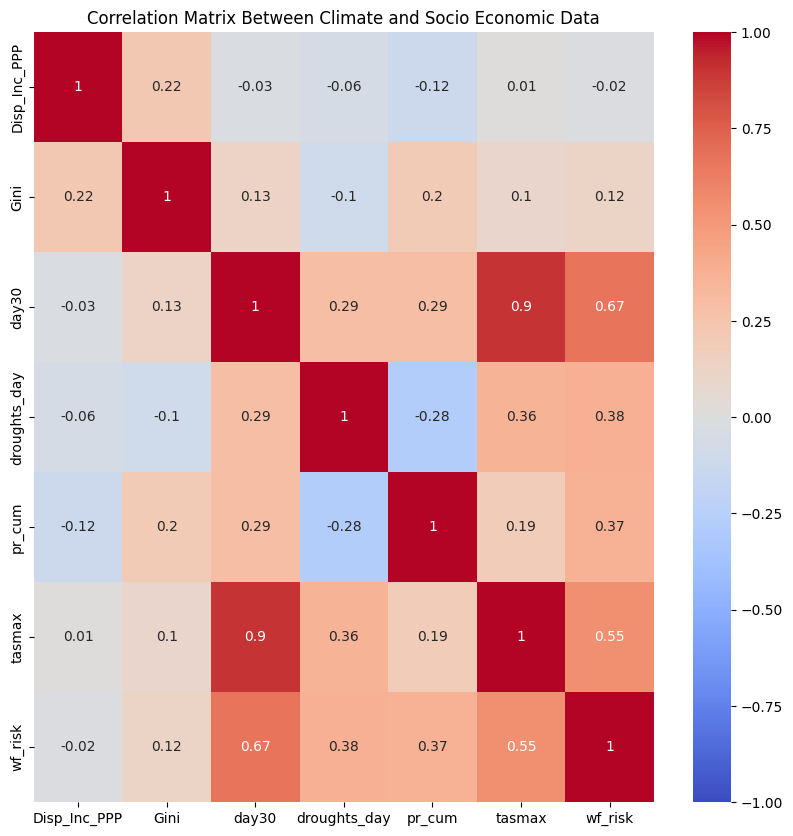

In [22]:
clim_df = clim_shp[['LAU_ID', 'AREA_KM2', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']]
clim_df = clim_df.merge(df_urban.drop(columns='AREA_KM2'), left_on='LAU_ID', right_on='LAU_ID', how='left')

clim_df_corr = clim_df[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP']].corr()

# nan_corr = ['urban', 'cropland', 'forest', 'wetland']
# for var in nan_corr:
#     for var2 in nan_corr:
#         clim_df_corr.loc[var, var2] = np.nan
# nan_corr = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']
# for var in nan_corr:
#     for var2 in nan_corr:
#         clim_df_corr.loc[var, var2] = np.nan
# clim_df_corr[clim_df_corr==1] = np.nan      

clim_df_corr=clim_df_corr.sort_index()
clim_df_corr = clim_df_corr.sort_index(axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(round(clim_df_corr,2), annot=True, cmap='coolwarm', ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix Between Climate and Socio Economic Data')

<Axes: title={'center': 'Correlation Matrix Between Climate and Socioeconomic Variables'}, ylabel='level_1'>

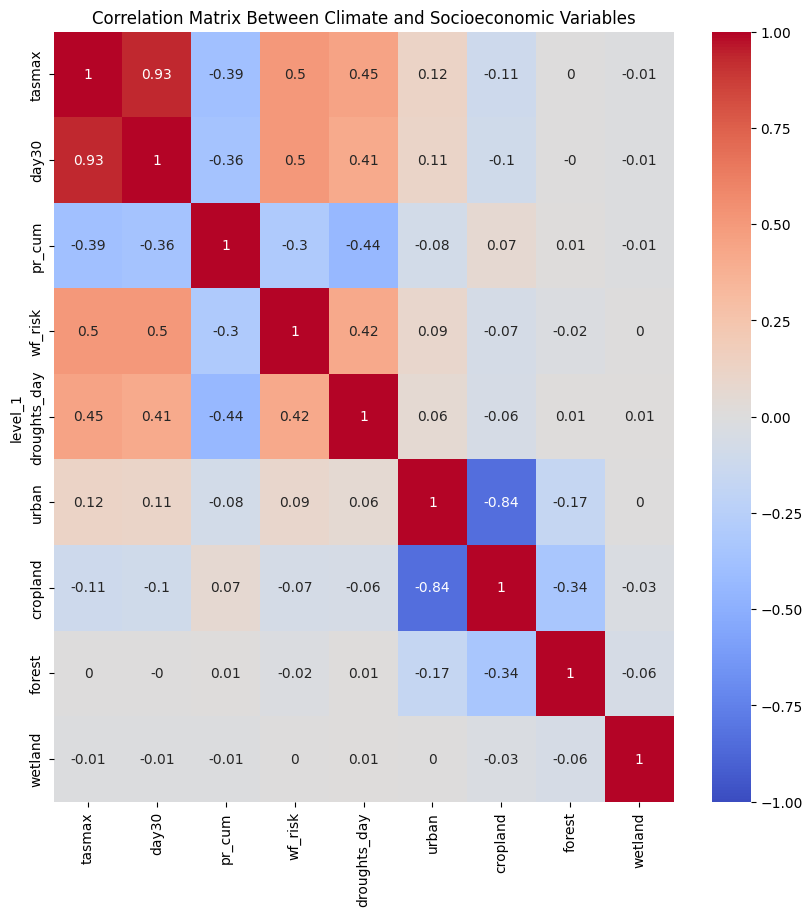

In [23]:
df_corr = clim_df.dropna(subset=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'urban', 'cropland', 'forest', 'wetland'])
df_corr = df_corr[['NUTS3_ID', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'urban', 'cropland', 'forest', 'wetland']].groupby('NUTS3_ID').corr().reset_index()
df_corr = df_corr.drop(columns='NUTS3_ID').groupby('level_1').mean()
df_corr = df_corr.reset_index()
df_corr['index'] = df_corr['level_1'].apply(lambda x: df_corr.columns.to_list().index(x))
df_corr = df_corr.sort_values('index')
df_corr = df_corr.drop('index', axis=1)
df_corr = df_corr.set_index('level_1')
# df_corr = df_corr.sort_index( )
# df_corr = df_corr.sort_index(axis=1)

# nan_corr = ['urban', 'cropland', 'forest', 'wetland']
# for var in nan_corr:
#     for var2 in nan_corr:
#         df_corr.loc[var, var2] = np.nan
# nan_corr = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']
# for var in nan_corr:
#     for var2 in nan_corr:
#         df_corr.loc[var, var2] = np.nan
# df_corr[df_corr==1] = np.nan      

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('Correlation Matrix Between Climate and Socioeconomic Variables')
sns.heatmap(round(df_corr,2), annot=True, cmap='coolwarm', ax=ax, vmin=-1, vmax=1)

<Axes: title={'center': 'Correlation Matrix Between Climate and Socioeconomic Variables'}, ylabel='level_1'>

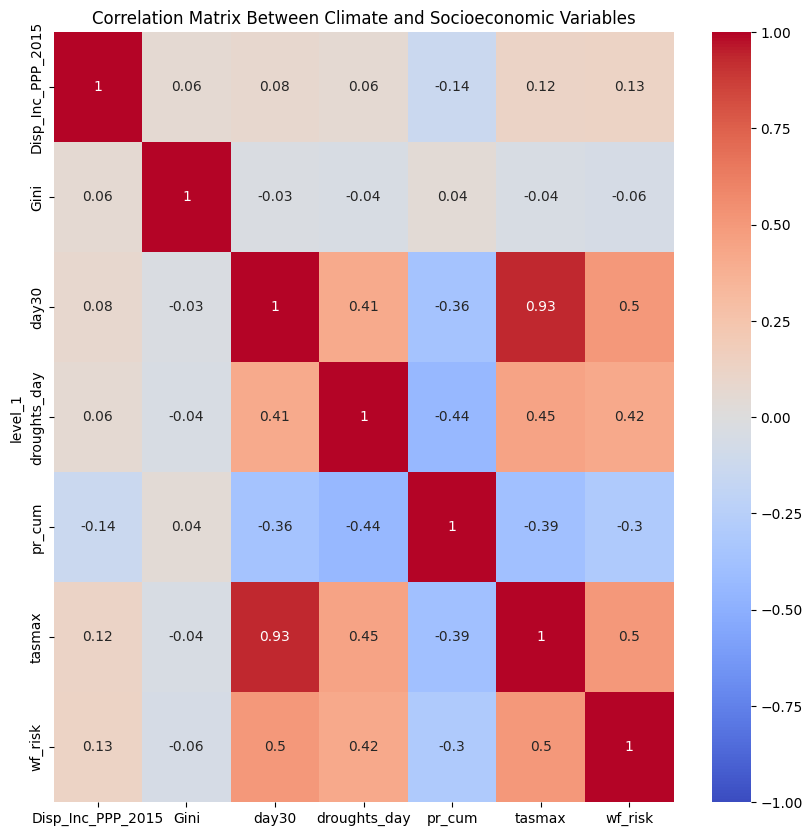

In [27]:
df_corr = clim_df.dropna(subset=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015'])
df_corr = df_corr[['NUTS3_ID', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015']].groupby('NUTS3_ID').corr().reset_index()
df_corr = df_corr.drop(columns='NUTS3_ID').groupby('level_1').mean()
df_corr = df_corr.sort_index( )
df_corr = df_corr.sort_index(axis=1)

# nan_corr = ['urban', 'cropland', 'forest', 'wetland']
# for var in nan_corr:
#     for var2 in nan_corr:
#         df_corr.loc[var, var2] = np.nan
# nan_corr = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']
# for var in nan_corr:
#     for var2 in nan_corr:
#         df_corr.loc[var, var2] = np.nan
# df_corr[df_corr==1] = np.nan      

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('Correlation Matrix Between Climate and Socioeconomic Variables')
sns.heatmap(round(df_corr,2), annot=True, cmap='coolwarm', ax=ax, vmin=-1, vmax=1)

In [31]:
df_corr = clim_df.dropna(subset=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015', 'urban', 'cropland', 'forest', 'wetland'])
df_corr

,LAU_ID,AREA_KM2,tasmax,day30,pr_cum,wf_risk,droughts_day,GISCO_ID,urban,cropland,...,POP_2023,LAU_NAME,NUTS3_ID,UR TYPO,COASTAL,AU_code,Gini,Disp_Inc_PPP_2015,Disp_Inc_PPP,Population
0,17315,98.405778,24.32,11.7,35.02,3,112,FR_17315,4.148345,-4.148380,...,1362.0,Saint-Christophe,FRI32,predominantly rural,coastal,17315,0.275465,16201.078928,16201.078928,1400.0
1,17316,21.734226,24.30,12.1,38.31,2,101,FR_17316,1.396078,-1.392726,...,397.0,Saint-Ciers-Champagne,FRI32,predominantly rural,coastal,17316,0.260103,15406.079163,15406.079163,418.0
2,17317,25.392222,24.38,12.0,38.76,2,127,FR_17317,1.567273,-1.575571,...,559.0,Saint-Ciers-du-Taillon,FRI32,predominantly rural,coastal,17317,0.260103,14168.724532,14168.724532,515.5
3,17318,95.759454,23.24,7.0,33.70,2,134,FR_17318,0.652510,-0.672627,...,682.0,Saint-Clément-des-Baleines,FRI32,predominantly rural,coastal,17318,0.304953,17627.579442,17627.579442,729.5
4,17319,24.239725,24.10,11.3,38.77,2,100,FR_17319,0.000000,-0.022437,...,107.0,Sainte-Colombe,FRI32,predominantly rural,coastal,17319,0.260103,15240.819165,15240.819165,111.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34940,77446,91.156683,22.92,7.2,32.87,2,126,FR_77446,-1.954526,0.444926,...,603.0,Savins,FR102,intermediate,non-coastal,77446,0.227429,18588.133808,18588.133808,609.5
34941,62056,108.557041,19.46,1.3,32.40,0,92,FR_62056,0.022722,-0.065871,...,634.0,Audresselles,FRE12,intermediate,coastal,62056,0.260209,14777.019365,14777.019365,660.5
34942,62088,102.074824,19.65,1.4,36.18,0,54,FR_62088,-0.037909,0.084054,...,328.0,Bayenghem-lès-Seninghem,FRE12,intermediate,coastal,62088,0.233799,16053.140989,16053.140989,316.5
34943,49018,43.761359,23.55,8.5,31.24,2,157,FR_49018,0.319698,-0.838186,...,11829.0,Baugé-en-Anjou,FRG02,intermediate,non-coastal,49018,0.234639,15063.697120,15063.697120,11399.0


In [ ]:
df_corr = clim_df.dropna(subset=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015', 'urban', 'cropland', 'forest', 'wetland'])
df_corr = df_corr[['NUTS3_ID', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015', 'urban', 'cropland', 'forest', 'wetland']].groupby('NUTS3_ID').corr().reset_index()
df_corr['UR TYPO'] = df_corr['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x]['UR TYPO'].values[0])
var_list = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']
df_corr = df_corr[df_corr.level_1.isin(['urban', 'Gini', 'Disp_Inc_PPP_2015'])]
fig, axs = plt.subplots(2,3, figsize=(15,15))
for i in range(5):
    ax = axs[i//3, i%3]
    sns.boxplot(x='level_1', y=var_list[i], data=df_corr, hue='UR TYPO', ax=ax)
    ax.set_title(var_list[i])
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Variable')
    ax.set_xticklabels(['Urban Change', 'Gini', 'Disposable Income'], rotation=45)


AttributeError: 'GeoDataFrame' object has no attribute 'NUTS3_ID'

Text(0.5, 1.0, 'Correlation Between Disposable Income and Tasmax')

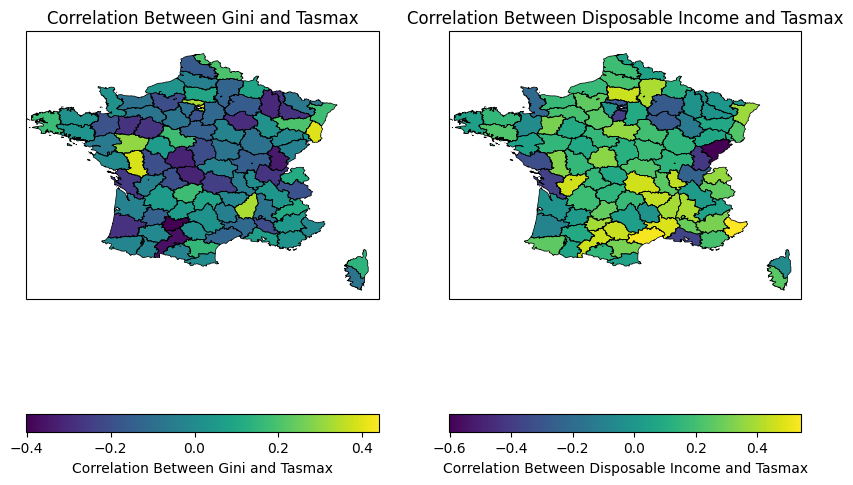

In [170]:
#plot nuts agg map with correlation between tasmax and Gini
df_corr = clim_df.dropna(subset=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015', 'urban', 'cropland', 'forest', 'wetland'])
df_corr = df_corr[['NUTS3_ID', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015', 'urban', 'cropland', 'forest', 'wetland']].groupby('NUTS3_ID').corr().reset_index()
df_corr['UR TYPO'] = df_corr['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x]['UR TYPO'].values[0])

nuts_temp = nuts3_agg.merge(df_corr[df_corr['level_1']=='tasmax'][['NUTS3_ID', 'Gini', 'Disp_Inc_PPP_2015']], left_on='NUTS3_ID',
                            right_on = 'NUTS3_ID', how='left')

fig,axs = plt.subplots(1,2, figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

nuts_temp = nuts_temp.to_crs(epsg=4326)
nuts3_agg = nuts3_agg.to_crs(epsg=4326)

ax = axs[0]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts_temp.plot(ax=ax, column='Gini', legend=True, legend_kwds={'label': "Correlation Between Gini and Tasmax", 'orientation': "horizontal"})
ax.set_extent([-5, 10, 41, 52])
ax.set_title('Correlation Between Gini and Tasmax')

ax = axs[1]
nuts3_agg.boundary.plot(ax=ax, color='black', linewidth=0.5)
nuts_temp.plot(ax=ax, column='Disp_Inc_PPP_2015', legend=True, legend_kwds={'label': "Correlation Between Disposable Income and Tasmax", 'orientation': "horizontal"})
ax.set_extent([-5, 10, 41, 52])
ax.set_title('Correlation Between Disposable Income and Tasmax')
                            

In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

nuts3_agg = nuts3_agg.reset_index()
df_panel = clim_df.dropna(subset=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015', 'urban'])
df_panel['NUTS3_TYPE'] = df_panel['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x]['UR TYPO'].values[0])
df_panel['NUTS3_TYPE'] = df_panel['NUTS3_TYPE'].astype('category')
# Set region as categorical variable (Fixed Effects via Dummy Variables)
df_panel['NUTS3_ID'] = df_panel['NUTS3_ID'].astype('category')

df_panel.to_csv('../../data/clim_df_panel.csv', index=False)

C:\Users\colin\AppData\Local\Temp\ipykernel_23568\2079838695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['NUTS3_TYPE'] = df_panel['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x]['UR TYPO'].values[0])
C:\Users\colin\AppData\Local\Temp\ipykernel_23568\2079838695.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['NUTS3_TYPE'] = df_panel['NUTS3_TYPE'].astype('category')
C:\Users\colin\AppData\Local\Temp\ipykernel_23568\2079838695.py:11: SettingWithCopyWarning: 
A value i

In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

nuts3_agg = nuts3_agg.reset_index()
df_panel = clim_df.dropna(subset=['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015', 'urban'])
df_panel['NUTS3_TYPE'] = df_panel['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x]['UR TYPO'].values[0])
df_panel['NUTS3_TYPE'] = df_panel['NUTS3_TYPE'].astype('category')
# Set region as categorical variable (Fixed Effects via Dummy Variables)
df_panel['NUTS3_ID'] = df_panel['NUTS3_ID'].astype('category')

# Step 1: First-stage regression (suspected endogenous variable on the instrument)
first_stage = smf.ols("Disp_Inc_PPP_2015 ~ tasmax + day30 + pr_cum + wf_risk + droughts_day + Gini", data=df_panel).fit()

# Get the residuals (differences between observed and predicted values)
df_panel["residuals"] = first_stage.resid

# Step 2: Second-stage regression (main equation including the residuals)
second_stage = smf.ols("urban ~ tasmax + day30 + pr_cum + wf_risk + droughts_day + Gini + Disp_Inc_PPP_2015 + residuals", data=df_panel).fit()

# Step 3: Check the p-value of the residuals
p_value = second_stage.pvalues["residuals"]
print(second_stage.summary())

# Step 4: Interpretation
if p_value < 0.05:
    print("⚠️ Endogeneity detected! Use Instrumental Variables (IV) regression instead of OLS.")
else:
    print("✅ No endogeneity detected. OLS estimates are consistent.")


                            OLS Regression Results                            
Dep. Variable:                  urban   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     170.4
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          1.44e-248
Time:                        10:13:52   Log-Likelihood:                -76346.
No. Observations:               31417   AIC:                         1.527e+05
Df Residuals:                   31409   BIC:                         1.528e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4991      0.51

C:\Users\colin\AppData\Local\Temp\ipykernel_23568\3722477866.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['NUTS3_TYPE'] = df_panel['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x]['UR TYPO'].values[0])
C:\Users\colin\AppData\Local\Temp\ipykernel_23568\3722477866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel['NUTS3_TYPE'] = df_panel['NUTS3_TYPE'].astype('category')
C:\Users\colin\AppData\Local\Temp\ipykernel_23568\3722477866.py:11: SettingWithCopyWarning: 
A value i

In [173]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numerical predictors
X = df_panel[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015']]

# Add a constant for VIF calculation
X = sm.add_constant(X)

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print VIF scores
print(vif_data)


            Variable         VIF
0              const  715.829383
1             tasmax    5.882209
2              day30    7.248470
3             pr_cum    1.757662
4            wf_risk    2.522024
5       droughts_day    1.747582
6               Gini    1.117866
7  Disp_Inc_PPP_2015    1.117296


In [33]:
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
# Normalize the data
scaler = StandardScaler()
df_panel[['day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015']] = scaler.fit_transform(df_panel[['day30', 'pr_cum', 'wf_risk', 'droughts_day', 'Gini', 'Disp_Inc_PPP_2015']])

# Run Fixed Effects Model (Region-Level)
model = smf.ols("urban ~  day30 + pr_cum + wf_risk + droughts_day + Gini + Disp_Inc_PPP_2015 + C(NUTS3_TYPE)", data=df_panel).fit()

# Print results
print(model.summary())


NameError: name 'df_panel' is not defined

### PPRN - Plan de Prévention des Risques Naturels

In [31]:
df_catnat = pd.read_csv('../../data/gaspar/catnat_gaspar.csv', sep=';')

df_catnat['start_year'] = pd.to_datetime(df_catnat['dat_deb'], format='%Y-%m-%d').dt.year
df_catnat['before_2005'] = (df_catnat['start_year'] <= 2005).astype(int)
df_catnat['after_2005'] = (df_catnat['start_year'] > 2005).astype(int)
df_catnat['nb_event']=1 
df_catnat = df_catnat[['cod_commune', 'before_2005', 'after_2005', 'nb_event']].groupby('cod_commune').sum().reset_index()

df_catnat = df_catnat.merge(df_urban, left_on='cod_commune', right_on='LAU_ID', how='left')
df_catnat.dropna(subset=['urban'], inplace=True)
df_catnat['exposed'] = (df_catnat['before_2005'] > 2) & (df_catnat['before_2005'] <=10).astype(int)
df_catnat['not_exposed'] = (df_catnat['before_2005'] < 3).astype(int)
df_catnat['very_exposed'] = (df_catnat['before_2005'] > 10).astype(int)

In [34]:
#make an ols model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_catnat[['Population', 'Gini', 'urban', 'cropland', 'forest', 'wetland']] = scaler.fit_transform(df_catnat[['Population', 'Gini', 'urban', 'cropland', 'forest', 'wetland']])

model = smf.ols("urban ~  not_exposed + very_exposed + Population + Gini", data=df_catnat).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  urban   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     152.5
Date:                Wed, 09 Apr 2025   Prob (F-statistic):          1.98e-129
Time:                        10:00:22   Log-Likelihood:                -42091.
No. Observations:               30286   AIC:                         8.419e+04
Df Residuals:                   30281   BIC:                         8.423e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0280      0.006     -4.357   

In [35]:
df_pprn = pd.read_csv('../../data/gaspar/pprn_gaspar.csv', sep=';')

df_pprn['start_year'] = pd.to_datetime(df_pprn['dat_prescription'], format='%Y-%m-%d').dt.year

df_pprn['pprn_before_2005'] = (df_pprn['start_year'] <= 2005).astype(int)
df_pprn['pprn_after_2005'] = (df_pprn['start_year'] > 2005).astype(int)

df_pprn = df_pprn[['cod_commune', 'pprn_before_2005', 'pprn_after_2005']].groupby('cod_commune').sum().reset_index()

df_pprn = df_catnat.merge(df_pprn, right_on='cod_commune', left_on='cod_commune', how='left')

df_pprn['pprn_before_2005'] = df_pprn['pprn_before_2005'].fillna(0)
df_pprn['pprn_after_2005'] = df_pprn['pprn_after_2005'].fillna(0)

df_pprn['well_adapted'] = (df_pprn['pprn_before_2005'] > 0).astype(int)
df_pprn['not_adapted'] = (df_pprn['pprn_before_2005'] == 0).astype(int)

df_pprn['diff'] = df_pprn['after_2005'] - df_pprn['before_2005']

df_pprn.rename(columns={'UR TYPO': 'UR_TYPO'}, inplace=True)
df_pprn.columns

C:\Users\colin\AppData\Local\Temp\ipykernel_13920\4232249507.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pprn = pd.read_csv('../../data/gaspar/pprn_gaspar.csv', sep=';')


Index(['cod_commune', 'before_2005', 'after_2005', 'nb_event', 'LAU_ID',
       'GISCO_ID', 'urban', 'cropland', 'forest', 'wetland', 'AREA_KM2',
       'POP_2023', 'LAU_NAME', 'NUTS3_ID', 'UR_TYPO', 'COASTAL', 'AU_code',
       'Gini', 'Disp_Inc_PPP_2015', 'Disp_Inc_PPP', 'Population', 'exposed',
       'not_exposed', 'very_exposed', 'pprn_before_2005', 'pprn_after_2005',
       'well_adapted', 'not_adapted', 'diff'],
      dtype='object')

In [189]:
scaler = StandardScaler()
df_pprn[['Population', 'Gini']] = scaler.fit_transform(df_pprn[['Population', 'Gini']])

model = smf.ols("urban ~  well_adapted + not_exposed + very_exposed + Population + Gini + not_adapted + diff +C(UR_TYPO)", data=df_pprn).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  urban   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     151.5
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          2.98e-251
Time:                        11:58:27   Log-Likelihood:                -41788.
No. Observations:               30276   AIC:                         8.359e+04
Df Residuals:                   30267   BIC:                         8.367e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

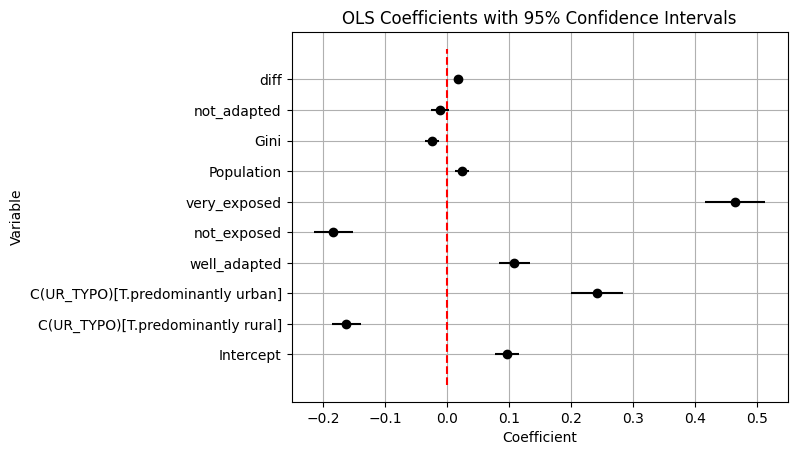

In [190]:
fig, ax = plt.subplots()
#plot the confidence interval as horizontal boxplots for each category for the OLS model
upper = model.conf_int().loc[:, 1]
lower = model.conf_int().loc[:, 0]
labels = model.params.index.values
preds = model.params.values
# preds.index = preds.str.replace(' ', '\n')

ax.errorbar(preds, labels, xerr=[preds - lower, upper - preds], fmt='o', color='black')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Variable')
ax.set_title('OLS Coefficients with 95% Confidence Intervals')

ax.vlines(0, -1, len(labels), color='red', linestyle='--')
ax.grid(True)


### Distance to cities

In [36]:
insee_pop = pd.read_excel('../../data/base-pop-historiques-1876-2022.xlsx', sheet_name='pop_1876_2022', skiprows=5)


In [37]:
insee_pop

,CODGEO,REG,DEP,LIBGEO,PMUN2022,PMUN2021,PMUN2020,PMUN2019,PMUN2018,PMUN2017,...,PTOT1926,PTOT1921,PTOT1911,PTOT1906,PTOT1901,PTOT1896,PTOT1891,PTOT1886,PTOT1881,PTOT1876
0,01001,84,01,L'Abergement-Clémenciat,859,832,806,779,771,776,...,543.0,566.0,560.0,629.0,637.0,572.0,594.0,622.0,605.0,604.0
1,01002,84,01,L'Abergement-de-Varey,273,267,262,256,253,248,...,253.0,256.0,291.0,323.0,357.0,391.0,421.0,486.0,490.0,484.0
2,01004,84,01,Ambérieu-en-Bugey,15554,14854,14288,14134,14204,14035,...,5705.0,4796.0,4334.0,4100.0,4023.0,3548.0,3635.0,3618.0,3396.0,3427.0
3,01005,84,01,Ambérieux-en-Dombes,1917,1897,1782,1751,1720,1689,...,690.0,698.0,805.0,805.0,835.0,852.0,862.0,882.0,879.0,848.0
4,01006,84,01,Ambléon,114,113,113,112,112,111,...,161.0,150.0,159.0,193.0,200.0,206.0,200.0,200.0,213.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34932,97420,4,974,Sainte-Suzanne,24855,24293,24086,24065,23718,23505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34933,97421,4,974,Salazie,7333,7243,7310,7136,7224,7312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34934,97422,4,974,Le Tampon,81964,81943,80778,79824,79385,78629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34935,97423,4,974,Les Trois-Bassins,7113,6899,6953,7015,7076,7139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_pop = df_urban.merge(insee_pop[['CODGEO', 'PMUN2018', 'PMUN2006']], left_on='LAU_ID', right_on='CODGEO', how='left')

In [39]:
df_pop['pop_changes'] = df_pop['PMUN2018'] - df_pop['PMUN2006']
lau_2023_dist = lau_2023.merge(df_pop[['LAU_ID', 'PMUN2018']], left_on='LAU_ID', right_on='LAU_ID', how='left')
lau_2023_dist['big_city'] = (lau_2023_dist['PMUN2018'] > 200000).astype(int)
big_cities = lau_2023_dist[lau_2023_dist['big_city']==1]
lau_2023_dist['dist_big_city'] = lau_2023_dist['geometry'].apply(lambda x: x.distance(big_cities.geometry).min())

In [40]:
df_pop = df_pop.merge(lau_2023_dist[['LAU_ID', 'dist_big_city']], left_on='LAU_ID', right_on='LAU_ID', how='left')

In [41]:
df_pop = df_pop.merge(clim_shp[['LAU_ID', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']], left_on='LAU_ID', right_on='LAU_ID', how='left')

In [42]:
df_panel = df_pop[['urban','Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'UR TYPO', 'NUTS3_ID']].dropna()
df_panel['UR TYPO'] = df_panel['UR TYPO'].astype('category')
df_panel = df_panel.rename(columns={'UR TYPO': 'UR_TYPO'})

In [43]:
scaler = StandardScaler()
df_panel[['urban','Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']] = scaler.fit_transform(df_panel[['urban','Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']])
model = smf.ols("urban ~  Gini + Disp_Inc_PPP + dist_big_city + pop_changes + PMUN2018 + tasmax + day30 +  pr_cum + wf_risk + droughts_day + C(NUTS3_ID)", data=df_panel).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  urban   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     34.16
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:01:10   Log-Likelihood:                -42872.
No. Observations:               31404   AIC:                         8.595e+04
Df Residuals:                   31299   BIC:                         8.683e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2704 

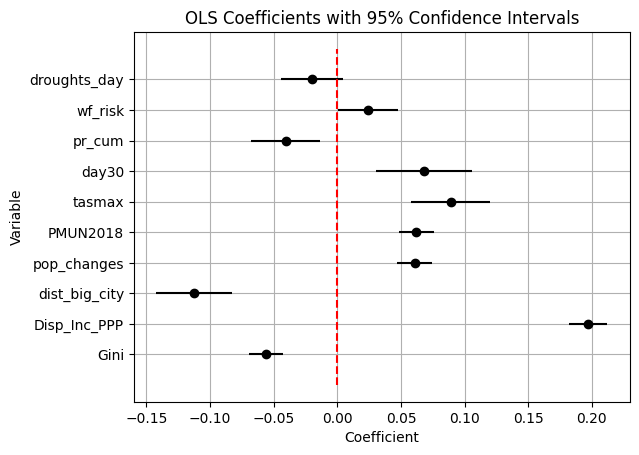

In [44]:
fig, ax = plt.subplots()
#plot the confidence interval as horizontal boxplots for each category for the OLS model
upper = model.conf_int().loc[:, 1]
lower = model.conf_int().loc[:, 0]
labels = model.params.index.values
preds = model.params.values

thr = 10

labels = labels[-thr:]
preds = preds[-thr:]
upper = upper[-thr:]
lower = lower[-thr:]

# preds.index = preds.str.replace(' ', '\n')

ax.errorbar(preds, labels, xerr=[preds - lower, upper - preds], fmt='o', color='black')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Variable')
ax.set_title('OLS Coefficients with 95% Confidence Intervals')

ax.vlines(0, -1, len(labels), color='red', linestyle='--')
ax.grid(True)

### Wildfires database

In [45]:
wf_shp = gpd.read_file('../../data/shp_wildfires_europe/modis.ba.poly.shp')
wf_shp = wf_shp[wf_shp.COUNTRY=='FR']

In [46]:
wf_shp_agg = gpd.sjoin(wf_shp, lau_2023, how='left', op='intersects')
wf_shp_agg[['AREA_HA', 'AREA_KM2']] = wf_shp_agg[['AREA_HA', 'AREA_KM2']].astype(float)
wf_shp_agg['FIREDATE'] = wf_shp_agg['FIREDATE'].str.split(' ').str[0]
wf_shp_agg['year_start'] = pd.to_datetime(wf_shp_agg['FIREDATE'], format='%Y-%m-%d').dt.year
wf_shp_agg = wf_shp_agg[['AREA_HA', 'GISCO_ID', 'LAU_NAME', 'LAU_ID', 'year_start', 'POP_2023', 'AREA_KM2', 'geometry', 'CNTR_CODE']]

c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\colin\AppData\Local\Temp\ipykernel_13920\4061013874.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84 ...
Right CRS: EPSG:4326

  wf_shp_agg = gpd.sjoin(wf_shp, lau_2023, how='left', op='intersects')


In [47]:
wf_shp_agg['before_2006'] = (wf_shp_agg['year_start'] < 2006).astype(int)
wf_shp_agg['noticeable'] = (wf_shp_agg['AREA_HA'] >= 10).astype(int)
wf_shp_agg['very_noticeable'] = (wf_shp_agg['AREA_HA'] >= 100).astype(int)
wf_shp_agg['id'] = 1

wf_shp_final = wf_shp_agg[['LAU_ID',  'before_2006', 'noticeable', 'very_noticeable', 'id']].groupby('LAU_ID').sum().reset_index()
wf_shp_final = wf_shp_final.merge(lau_2023, left_on='LAU_ID', right_on='LAU_ID', how='left')

In [49]:
df = pd.merge(df_urban, lau_2023[['LAU_ID', 'geometry']], left_on='LAU_ID', right_on='LAU_ID', how='left')
df = gpd.GeoDataFrame(df).to_crs(epsg=4326)
df_wf = gpd.sjoin(df, gpd.GeoDataFrame(wf_shp_final[['LAU_ID','geometry', 'id', 'noticeable', 'very_noticeable', 'before_2006']]).to_crs(epsg=4326), how='left', op='intersects')
# df_wf = df_wf.sort_values('id', ascending=False).drop_duplicates(subset='LAU_ID')
df_wf = df_wf.sort_values('id', ascending=False)
df_wf.drop_duplicates(subset='LAU_ID_left', inplace=True)
df_wf = df_wf.drop(columns=['index_right', 'geometry', 'LAU_ID_right'])
df_wf = df_wf.rename(columns={'LAU_ID_left': 'LAU_ID'})

c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [50]:
# Fill missing values in df_wf
df_wf = df_wf.fillna({
    'id': 0,
    'noticeable': 0,
    'very_noticeable': 0,
    'before_2006': 0
})

df_wf['diff'] = df_wf['id'] - df_wf['before_2006']

In [51]:
df_wf_exposed = df_wf[df_wf['id'] > 0]

In [52]:
df_wf_exposed[df_wf_exposed.before_2006>0].urban.mean() - df_wf_exposed[df_wf_exposed.before_2006==0].urban.mean()

0.5144575970800731

In [ ]:
df_wf_exposed[df_wf_exposed.noticeable>0].urban.mean() - df_wf_exposed.urban.mean()

(950, 22)

In [88]:
df_panel = df_pop.merge(df_wf[['LAU_ID', 'id', 'noticeable', 'very_noticeable', 'before_2006']], left_on='LAU_ID', right_on='LAU_ID', how='left')
scaler = StandardScaler()
df_panel[['urban','Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'before_2006', 'noticeable', 'very_noticeable','id']] = scaler.fit_transform(df_panel[['urban','Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'before_2006', 'noticeable', 'very_noticeable', 'id']])
model = smf.ols("urban ~  Gini + Disp_Inc_PPP + dist_big_city + pop_changes + PMUN2018 + id + C(NUTS3_ID)", data=df_panel).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  urban   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     32.55
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:00:54   Log-Likelihood:                -43015.
No. Observations:               31404   AIC:                         8.623e+04
Df Residuals:                   31303   BIC:                         8.708e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0233 

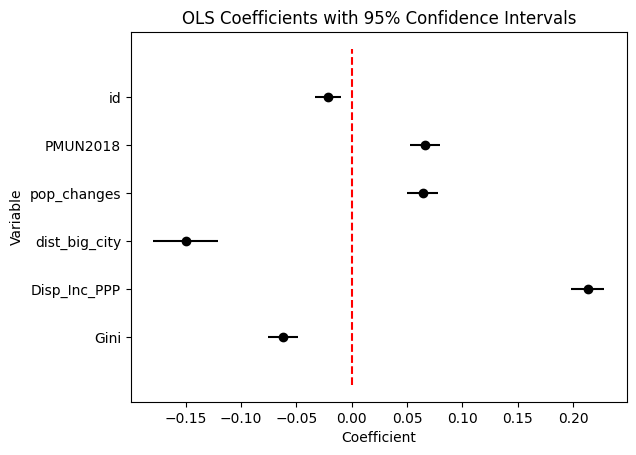

In [89]:
fig, ax = plt.subplots()
#plot the confidence interval as horizontal boxplots for each category for the OLS model
upper = model.conf_int().loc[:, 1]
lower = model.conf_int().loc[:, 0]
labels = model.params.index.values
preds = model.params.values
thr = 6
labels = labels[-thr:]
preds = preds[-thr:]
upper = upper[-thr:]
lower = lower[-thr:]
# preds.index = preds.str.replace(' ', '\n')

ax.errorbar(preds, labels, xerr=[preds - lower, upper - preds], fmt='o', color='black')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Variable')

ax.set_title('OLS Coefficients with 95% Confidence Intervals')
ax.vlines(0, -1, len(labels), color='red', linestyle='--')

### Voting Database

In [69]:
df_vote = pd.read_csv('C:/Users/colin/Downloads/pres2022comm.csv')

C:\Users\colin\AppData\Local\Temp\ipykernel_13920\3767417969.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vote = pd.read_csv('C:/Users/colin/Downloads/pres2022comm.csv')


In [71]:
nuts3_agg

,geometry,UR TYPO,COASTAL
NUTS3_ID,,,
FR101,"POLYGON ((2.41531 48.85517, 2.41634 48.84923, ...",predominantly urban,non-coastal
FR102,"POLYGON ((2.47185 48.15459, 2.47785 48.15635, ...",intermediate,non-coastal
FR103,"POLYGON ((1.87945 48.44067, 1.87120 48.44020, ...",predominantly urban,non-coastal
FR104,"POLYGON ((2.05271 48.29547, 2.05146 48.29021, ...",predominantly urban,non-coastal
FR105,"POLYGON ((2.27451 48.74072, 2.28459 48.74679, ...",predominantly urban,non-coastal
...,...,...,...
FRY10,"MULTIPOLYGON (((-61.60327 15.83431, -61.60528 ...",intermediate,coastal
FRY20,"MULTIPOLYGON (((-60.83133 14.42061, -60.82760 ...",intermediate,coastal
FRY30,"MULTIPOLYGON (((-52.04380 3.55032, -52.06027 3...",intermediate,coastal


In [72]:
df_vote['codecommune'] = df_vote['codecommune'].astype(str)
df_catnat['cod_commune'] = df_catnat['cod_commune'].astype(str)
# df_catnat = df_catnat.merge(nuts3[['LAU_ID', 'NUTS3_ID']], left_on='LAU_ID', right_on='LAU_ID', how='left')
# df_catnat['NUTS3_TYPE'] = df_catnat['NUTS3_ID'].apply(lambda x: nuts3_agg[nuts3_agg.NUTS3_ID==x].NUTS3_TYPE.values[0])

#for codecommune with only 4 digits, add a 0 at the beginning
df_vote['codecommune'] = df_vote['codecommune'].apply(lambda x: '0'+x if len(x)==4 else x)

In [81]:
df_temp = df_catnat.merge(df_vote[['pvoixMLEPEN','pvoixMELENCHON', 'pvoixMACRON','pvoixPECRESSE', 'pvoixJADOT', 'codecommune']], right_on='codecommune', left_on='cod_commune', how='right')
df_temp = df_temp.dropna()
df_temp['catnat_km2'] = df_temp['nb_event']/df_temp['AREA_KM2']
df_temp = df_temp.merge(df_pop[['dist_big_city', 'pop_changes', 'PMUN2018', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'LAU_ID']], left_on='cod_commune', right_on='LAU_ID', how='left')
# df_temp = df_temp[df_temp.NUTS3_TYPE=='Rural region']

In [86]:
df_panel = df_temp[['catnat_km2', 'pvoixMLEPEN', 'Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']].dropna()
scaler = StandardScaler()
df_panel[['catnat_km2', 'pvoixMLEPEN', 'Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']] = scaler.fit_transform(df_panel[['catnat_km2', 'pvoixMLEPEN', 'Gini', 'Disp_Inc_PPP', 'dist_big_city', 'pop_changes', 'PMUN2018', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']])

model = smf.ols("pvoixMLEPEN ~  catnat_km2 + Gini + Disp_Inc_PPP + dist_big_city + pop_changes + PMUN2018", data=df_panel).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            pvoixMLEPEN   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     815.8
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:57:52   Log-Likelihood:                -40655.
No. Observations:               30251   AIC:                         8.132e+04
Df Residuals:                   30244   BIC:                         8.138e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.245e-17      0.005   1.17e-14

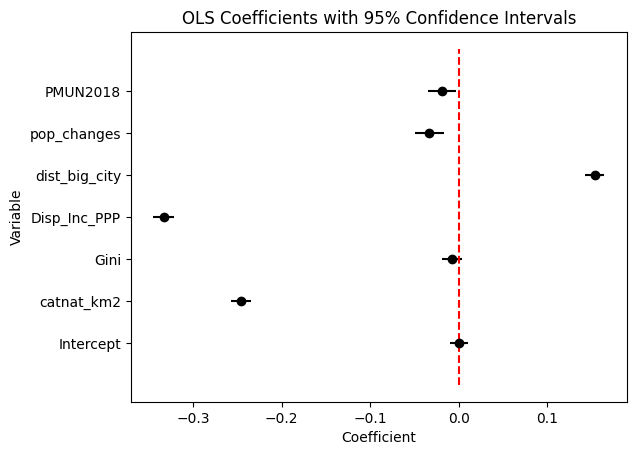

In [87]:
fig, ax = plt.subplots()
#plot the confidence interval as horizontal boxplots for each category for the OLS model²
upper = model.conf_int().loc[:, 1]
lower = model.conf_int().loc[:, 0]

labels = model.params.index.values
preds = model.params.values

thr = 10

labels = labels[-thr:]
preds = preds[-thr:]
upper = upper[-thr:]
lower = lower[-thr:]
# preds.index = preds.str.replace(' ', '\n')

ax.errorbar(preds, labels, xerr=[preds - lower, upper - preds], fmt='o', color='black')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Variable')
ax.set_title('OLS Coefficients with 95% Confidence Intervals')

ax.vlines(0, -1, len(labels), color='red', linestyle='--')

### Future climate

In [100]:
clim_fut = pd.read_csv('../../data/indicesCCLM4-8-17_MPI-ESM_25040911092929203.txt', sep=';', comment='#', header=None)
clim_fut.columns = ['index', 'lat', 'lon', 'Contexte', 'Année', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day', 'nan']
clim_fut = clim_fut.drop('nan', axis=1)
clim_fut = clim_fut[['index', 'lat', 'lon', 'Année', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']].groupby(['index', 'lat', 'lon']).mean().reset_index()
clim_fut = clim_fut.drop(columns=['Année'])

In [133]:

#map the data_new to each county in the shapefile based on the closest lat lon
from scipy.spatial import distance
def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

clim_df_fut = lau_2023.copy()
clim_df_fut = clim_df_fut.to_crs(epsg=4326)
clim_df_fut['lat'] = clim_df_fut.geometry.centroid.y
clim_df_fut['lon'] = clim_df_fut.geometry.centroid.x
clim_df_fut['index'] = clim_df_fut.apply(lambda x: closest_node([x['lat'], x['lon']], clim_fut[['lat', 'lon']].values), axis=1)

C:\Users\colin\AppData\Local\Temp\ipykernel_13920\808194070.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clim_df_fut['lat'] = clim_df_fut.geometry.centroid.y
C:\Users\colin\AppData\Local\Temp\ipykernel_13920\808194070.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clim_df_fut['lon'] = clim_df_fut.geometry.centroid.x


In [134]:
clim_df_fut['pr_cum'] = clim_df_fut['index'].apply(lambda x: clim_fut.loc[x, 'pr_cum'])
clim_df_fut['tasmax'] = clim_df_fut['index'].apply(lambda x: clim_fut.loc[x, 'tasmax'])
clim_df_fut['wf_risk'] = clim_df_fut['index'].apply(lambda x: clim_fut.loc[x, 'wf_risk'])
clim_df_fut['droughts_day'] = clim_df_fut['index'].apply(lambda x: clim_fut.loc[x, 'droughts_day'])
clim_df_fut['day30'] = clim_df_fut['index'].apply(lambda x: clim_fut.loc[x, 'day30'])
clim_df_fut = clim_df_fut.drop(columns=['lat', 'lon', 'index'])

In [147]:
clim_diff = clim_df_fut.copy()
clim_diff[['pr_cum', 'tasmax', 'wf_risk', 'droughts_day', 'day30']] = clim_df_fut[['pr_cum', 'tasmax', 'wf_risk', 'droughts_day', 'day30']] - clim_shp[['pr_cum', 'tasmax', 'wf_risk', 'droughts_day', 'day30']]
clim_diff = clim_diff.merge(df_urban[['LAU_ID', 'urban']], left_on='LAU_ID', right_on='LAU_ID', how='left')
clim_diff['decile_urban'] = pd.qcut(clim_diff['urban'], 11, labels=False, duplicates='drop')

In [148]:
clim_diff.describe()

,POP_2023,POP_DENS_2,AREA_KM2,YEAR,pr_cum,tasmax,wf_risk,droughts_day,day30,urban,decile_urban
count,3.494500e+04,0.0,34945.000000,34945.0,34945.000000,34945.000000,34945.000000,34945.000000,34945.000000,31417.000000,31417.000000
mean,1.925167e+03,NaN,164.365465,2023.0,-15.048467,2.651977,2.885451,22.736344,14.401341,1.342977,4.101983
std,1.507612e+04,NaN,742.011323,0.0,7.341676,0.331257,2.667043,11.803507,6.542290,2.800473,2.988994
min,0.000000e+00,NaN,0.000000,2023.0,-88.177000,-3.872500,-17.200000,-63.800000,-14.650000,-25.815466,0.000000
25%,1.980000e+02,NaN,18.354119,2023.0,-16.013000,2.547000,1.100000,15.050000,9.850000,0.000000,1.000000
50%,4.570000e+02,NaN,40.501779,2023.0,-12.626000,2.676000,2.100000,21.400000,13.600000,0.196035,4.000000
75%,1.160000e+03,NaN,96.439389,2023.0,-11.084000,2.781000,3.800000,29.200000,18.400000,1.674951,7.000000
max,2.165423e+06,NaN,27320.390643,2023.0,-6.233500,14.650000,18.900000,110.200000,35.750000,42.751595,9.000000


In [ ]:
clim_shp.describe()

,urban,cropland,forest,wetland,AREA_KM2,POP_2023,Gini,Disp_Inc_PPP_2015,Disp_Inc_PPP,Population
count,31427.000000,31427.000000,31427.000000,31427.000000,31427.000000,3.142700e+04,31427.000000,31427.000000,31427.000000,3.043500e+04
mean,1.342630,-1.227275,-0.120899,0.005544,179.652453,2.063973e+03,0.255261,16302.049544,16302.049544,1.176964e+03
std,2.800176,3.072550,1.688000,0.383161,779.221125,1.579204e+04,0.022487,1745.086188,1745.086188,1.323164e+04
min,-25.815466,-42.181950,-64.423655,-33.822658,0.000000,0.000000e+00,0.170441,10441.593603,10441.593603,7.500000e+01
25%,0.000000,-1.692435,-0.053988,0.000000,22.540742,2.520000e+02,0.242345,15215.264903,15215.264903,2.450000e+02
50%,0.196035,-0.237795,0.000000,0.000000,46.512972,5.330000e+02,0.254341,16031.302958,16031.302958,5.020000e+02
75%,1.674591,0.001383,0.013522,0.000000,106.927963,1.290000e+03,0.265959,17033.339237,17033.339237,1.146500e+03
max,42.751595,63.669610,35.578961,23.005923,27320.390643,2.165423e+06,0.440434,30209.992412,30209.992412,2.096399e+06


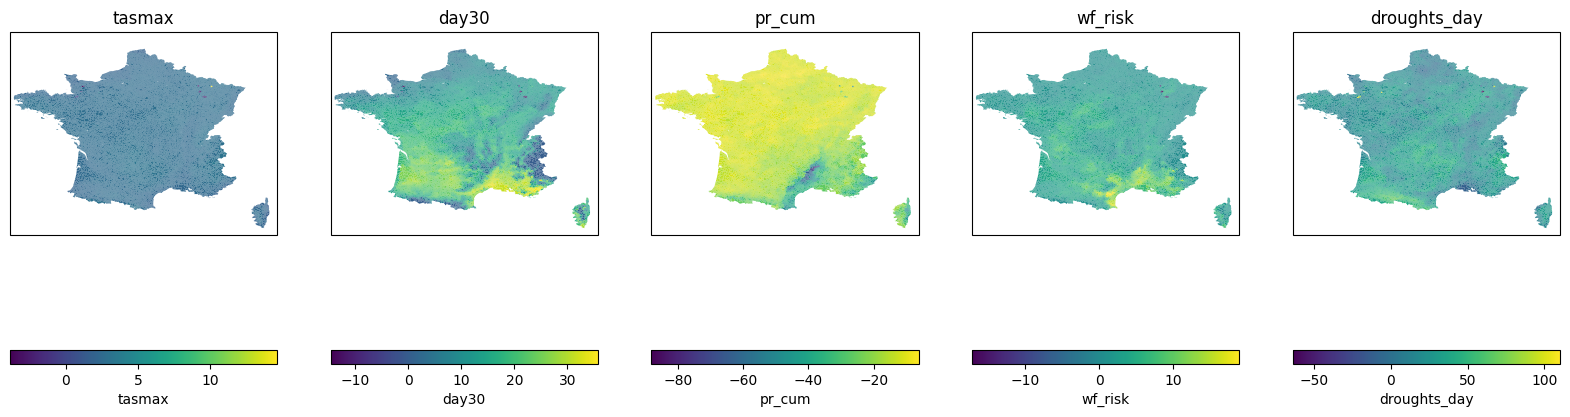

In [110]:
fig,axs = plt.subplots(1,5,figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
var_list = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']

for var in var_list:
    ax = axs[var_list.index(var)]
    clim_diff.plot(ax=ax, column=var, legend=True, legend_kwds={'label': var, 'orientation': "horizontal"})
    ax.set_extent([-5, 10, 41, 52])
    ax.set_title(var)


In [149]:
clim_diff[['pr_cum', 'tasmax', 'wf_risk', 'droughts_day', 'day30', 'decile_urban']].groupby('decile_urban').mean()


,pr_cum,tasmax,wf_risk,droughts_day,day30
decile_urban,,,,,
0.0,-13.810290,2.654040,2.385527,20.331922,13.289482
1.0,-15.679632,2.690430,3.100511,25.830489,15.198302
2.0,-15.155767,2.768153,2.811364,25.552983,14.231534
3.0,-13.175311,2.635962,2.149667,20.209821,12.224020
4.0,-14.020002,2.692321,2.609279,21.800753,13.491912
5.0,-14.157869,2.647095,2.708403,20.509296,13.878641
6.0,-14.807566,2.618140,2.890564,20.679517,14.341772
7.0,-14.786222,2.626722,3.130182,20.623634,15.143137
8.0,-15.416069,2.602507,3.317332,20.389408,15.585399


C:\Users\colin\AppData\Local\Temp\ipykernel_13920\1670338543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_plot[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']] = scaler.fit_transform(clim_plot[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']])
C:\Users\colin\AppData\Local\Temp\ipykernel_13920\1670338543.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='decile_urban', y=var, data=clim_plot, ax=ax, palette='coolwarm')
C:\Users\colin\AppData\Local\Temp\ipykernel_13920\1670338543.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

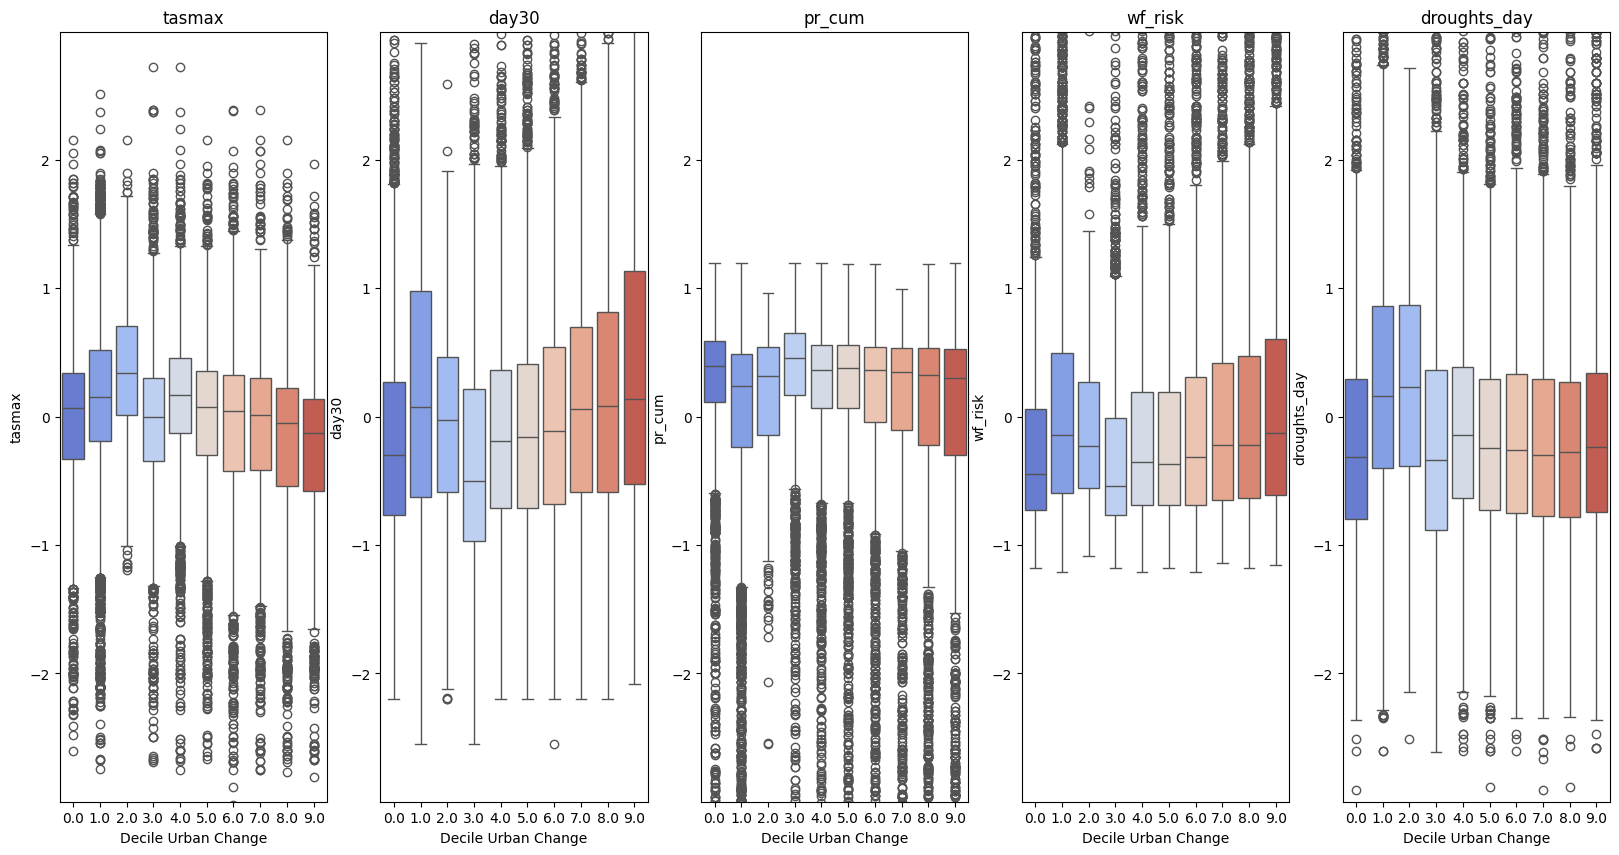

In [169]:

fig, axs = plt.subplots(1,5, figsize=(20, 10))

var_list = ['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']

clim_plot = clim_diff[['decile_urban', 'tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']]
scaler = StandardScaler()
clim_plot[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']] = scaler.fit_transform(clim_plot[['tasmax', 'day30', 'pr_cum', 'wf_risk', 'droughts_day']])

for var in var_list:
    ax = axs[var_list.index(var)]
    sns.boxplot(x='decile_urban', y=var, data=clim_plot, ax=ax, palette='coolwarm')
    ax.set_title(var)
    ax.set_xlabel('Decile Urban Change')
    ax.set_ylim(-3,3)
    ax.set_yticks(np.arange(-2, 3, 1))
    # ax.set_yticklabels(np.arange(-2, 3, 1), rotation=45)



In [172]:
clim_df_fut = clim_df_fut.merge(df_urban[['LAU_ID', 'urban']], left_on='LAU_ID', right_on='LAU_ID', how='left')
clim_df_fut['decile_urban'] = pd.qcut(clim_df_fut['urban'], 11, labels=False, duplicates='drop')

clim_df_fut[['pr_cum', 'tasmax', 'wf_risk', 'droughts_day', 'day30', 'decile_urban']].groupby('decile_urban').mean()

,pr_cum,tasmax,wf_risk,droughts_day,day30
decile_urban,,,,,
0.0,25.549357,25.177057,4.069811,108.327021,20.462986
1.0,27.739618,25.504019,4.708350,110.568318,23.675834
2.0,27.011847,25.289148,4.189205,111.831392,21.771875
3.0,25.231619,24.755112,3.490004,108.150648,18.449020
4.0,26.197260,25.137227,4.329167,110.242630,20.619293
5.0,25.862261,25.302519,4.864916,112.488288,21.529832
6.0,26.313102,25.463571,5.372707,113.147304,22.529832
7.0,26.522763,25.700938,5.822759,112.451716,24.062920
8.0,26.531879,25.835960,6.628606,113.977644,25.253221


In [161]:
clim_plot

,decile_urban,tasmax,day30,pr_cum,wf_risk,droughts_day
0,8.0,0.066484,0.878705,0.843956,-0.013293,-0.850297
1,6.0,-0.141816,0.771707,0.395074,1.111565,-0.591896
2,7.0,-0.233891,0.924561,0.356186,0.811603,-0.879950
3,5.0,0.572142,0.649424,0.496892,-0.219516,-0.591896
4,1.0,-0.131250,0.725851,0.434031,1.711489,0.352752
...,...,...,...,...,...,...
34940,0.0,0.099692,-0.282985,0.215889,-0.650712,-0.570715
34941,3.0,-1.095773,-1.437031,0.795806,-0.856936,-1.477238
34942,0.0,-0.833133,-1.406460,0.621797,-1.006917,-0.435160
34943,4.0,0.193276,0.221433,0.307627,0.492893,-0.159814


In [4]:
import requests

# URL de base du service WFS de Géorisques
base_url = 	"https://georisques.gouv.fr/api"

# Paramètres de la requête GetFeature
name = "OLD"

#try to get the data from the API
response = requests.get(f"{base_url}/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName={name}&outputFormat=json")
if response.status_code == 200:
    data = response.json()

    # Convertir les données en DataFrame
    df = pd.json_normalize(data['features'])
    # Afficher les 5 premières lignes du DataFrame
    print(df.head())
else:
    print(f"Erreur lors de la récupération des données : {response.status_code}")
    




Erreur lors de la récupération des données : 404


In [15]:
import requests
from xml.etree import ElementTree as ET

# URL du service WFS
url = "https://georisques.gouv.fr/services"

# Paramètres de la requête GetCapabilities
params = {
    "SERVICE": "WFS",
    "VERSION": "1.1.0",
    "REQUEST": "GetCapabilities"
}

# Effectuer la requête
response = requests.get(url, params=params)

# Vérifier si la requête a réussi
if response.status_code == 200:
    # Analyser le XML
    tree = ET.fromstring(response.content)
    namespaces = {
        'wfs': 'http://www.opengis.net/wfs',
        'ows': 'http://www.opengis.net/ows'
    }
    # Trouver tous les noms de couches
    feature_types = tree.findall('.//wfs:FeatureType', namespaces)
    for ft in feature_types:
        name = ft.find('wfs:Name', namespaces)
        title = ft.find('wfs:Title', namespaces)
        if name is not None and title is not None:
            print(f"Nom de la couche : {name.text} | Titre : {title.text}")
else:
    print(f"Erreur lors de la requête GetCapabilities : {response.status_code}")


Nom de la couche : CAVITE_LOCALISEE | Titre : Cavités souterraines abandonnées d'origine non minière
Nom de la couche : MVT_LOCALISE | Titre : Mouvements de Terrain
Nom de la couche : ALEARG_REALISE | Titre : Exposition au retrait-gonflement des argiles
Nom de la couche : SIS_INTENSITE_EVTCOM | Titre : Sismicité - Intensité interpolée - Nombre d'évènements par communes
Nom de la couche : SIS_INTENSITE_NBEVTCOM | Titre : Sismicité - Intensité interpolée - Nombre d'évènements par communes
Nom de la couche : INSTALLATIONS_NUCLEAIRES | Titre : Installations nucléaires de base (INB)
Nom de la couche : ETABLISSEMENTS_POLLUEURS | Titre : Etablissements Pollueurs
Nom de la couche : PPRN_COMMUNE_AVALANCHE_APPROUV | Titre : Communes concernées par un PPR Avalanche approuvé
Nom de la couche : PPRN_COMMUNE_AVALANCHE_PRESCRIT | Titre : Communes concernées par un PPR Avalanche prescrit
Nom de la couche : PPRN_COMMUNE_ATMOS_APPROUV | Titre : Communes concernées par un PPR Phénomènes météorologiques a